In [1]:
import csv
import os
import re
import glob
import time
import pickle
import datetime
import warnings
import logging
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
import scipy.stats as ss
from scipy.stats import pearsonr, spearmanr
from datetime import date, datetime
import ukbiobank.utils.utils
from ukbiobank.utils import fieldNamesToIds
from ukbiobank.utils import loadCsv
from ukbiobank.utils import addFields
from ukbiobank.utils.utils import getFieldnames
from ukbiobank.utils.utils import fieldIdsToNames
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [ ]:
# Upload UK Bioabank csv
csv_path = '/UK_BB/ukbbdata/ukb.csv'
ukb = ukbiobank.ukbio(ukb_csv=csv_path)

In [ ]:
# Create directories
base_path = f'/UK_BB/brainbody'
brain_path = os.path.join(base_path, 'brain')
data_path = os.path.join(brain_path, 'data')
shap_path = os.path.join(brain_path, 'shap')
os.makedirs(base_path, exist_ok=True)
os.makedirs(brain_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(shap_path, exist_ok=True)

## T1w phenotypes (IDPs)

- 1101	Regional grey matter volumes (FAST)	139
- 1102	Subcortical volumes (FIRST)	14
- 190	Freesurfer ASEG	99 - 2
- 195	Freesurfer BA exvivo	84
- 197	Freesurfer a2009s	444
- 196	Freesurfer DKT	186
- 194	Freesurfer desikan gw	70
- 193	Freesurfer desikan pial	66
- 192	Freesurfer desikan white	202
- 191	Freesurfer subsegmentation	121

### 1. Regional grey matter volumes (FAST)

Get the fields

In [ ]:
# Upload data
df_struct_fast = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
25888,
25889,
25822,
25823,
25892,
25880,
25881,
25864,
25865,
25838,
25839,
25840,
25841,
25900,
25902,
25901,
25903,
25905,
25904,
25844,
25845,
25830,
25831,
25862,
25863,
25846,
25847,
25782,
25783,
25870,
25871,
25886,
25887,
25893,
25894,
25915,
25917,
25916,
25792,
25793,
25790,
25791,
25808,
25809,
25810,
25811,
25812,
25813,
25784,
25785,
25828,
25829,
25832,
25833,
25826,
25827,
25824,
25825,
25852,
25853,
25788,
25789,
25802,
25803,
25804,
25805,
25806,
25807,
25860,
25861,
25876,
25877,
25884,
25885,
25836,
25837,
25848,
25849,
25850,
25851,
25866,
25867,
25868,
25869,
25872,
25873,
25814,
25815,
25794,
25795,
25842,
25843,
25882,
25883,
25834,
25835,
25786,
25787,
25816,
25817,
25798,
25799,
25800,
25801,
25874,
25875,
25818,
25819,
25820,
25821,
25854,
25855,
25856,
25857,
25858,
25859,
25796,
25797,
25878,
25879,
25895,
25896,
25897,
25899,
25898,
25909,
25911,
25910,
25912,
25914,
25913,
25906,
25908,
25907,
25890,
25891,
25918,
25919,
25920], instance=2)

struct_fast_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_struct_fast)

In [ ]:
# Drop NAs, remove instance number, and save
struct_fast_names_nona = struct_fast_names.dropna(axis=0)
struct_fast_names_nona.columns = struct_fast_names_nona.columns.str.replace('-2.0', '')
struct_fast_names_nona.to_csv(os.path.join(data_path, 'sMRI/struct_fast_names_nona.csv'), index=False)
struct_fast_names_nona

### 2. Subcortical volumes (FIRST)

In [ ]:
df_struct_sub_first = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
25023,
25024,
25021,
25022,
25013,
25014,
25019,
25020,
25017,
25018,
25015,
25016,
25011,
25012], instance=2)
struct_sub_first_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_struct_sub_first)

Drop NAs, remove instance number, and save

In [ ]:
struct_sub_first_names_nona = struct_sub_first_names.dropna(axis=0)
struct_sub_first_names_nona.columns = struct_sub_first_names_nona.columns.str.replace('-2.0', '')
struct_sub_first_names_nona.to_csv(os.path.join(data_path, 'sMRI/struct_sub_first_names_nona.csv'), index=False)
#struct_sub_first_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_sub_first_names_nona.csv'))
struct_sub_first_names_nona

### 3. Freesurfer ASEG

- 26501	Mean intensity of 3rd-Ventricle (whole brain)
- 26502	Mean intensity of 4th-Ventricle (whole brain)
- 26503	Mean intensity of 5th-Ventricle (whole brain)
- 26548	Mean intensity of Accumbens-area (left hemisphere)
- 26579	Mean intensity of Accumbens-area (right hemisphere)
- 26547	Mean intensity of Amygdala (left hemisphere)
- 26578	Mean intensity of Amygdala (right hemisphere)
- 26504	Mean intensity of Brain-Stem (whole brain)
- 26513	Mean intensity of CC-Anterior (whole brain)
- 26511	Mean intensity of CC-Central (whole brain)
- 26512	Mean intensity of CC-Mid-Anterior (whole brain)
- 26510	Mean intensity of CC-Mid-Posterior (whole brain)
- 26509	Mean intensity of CC-Posterior (whole brain)
- 26505	Mean intensity of CSF (whole brain)
- 26543	Mean intensity of Caudate (left hemisphere)
- 26574	Mean intensity of Caudate (right hemisphere)
- 26541	Mean intensity of Cerebellum-Cortex (left hemisphere)
- 26572	Mean intensity of Cerebellum-Cortex (right hemisphere)
- 26540	Mean intensity of Cerebellum-White-Matter (left hemisphere)
- 26571	Mean intensity of Cerebellum-White-Matter (right hemisphere)
- 26546	Mean intensity of Hippocampus (left hemisphere)
- 26577	Mean intensity of Hippocampus (right hemisphere)
- 26577	Mean intensity of Hippocampus (right hemisphere)
- 26539	Mean intensity of Inf- Lat- Vent (left hemisphere)
- 26570	Mean intensity of Inf- Lat- Vent (right hemisphere)
- 26538	Mean intensity of Lateral- Ventricle (left hemisphere)
- 26569	Mean intensity of Lateral- Ventricle (right hemisphere)
- 26508	Mean intensity of Optic- Chiasm (whole brain)
- 26545	Mean intensity of Pallidum (left hemisphere)
- 26576	Mean intensity of Pallidum (right hemisphere)
- 26544	Mean intensity of Putamen (left hemisphere)
- 26575	Mean intensity of Putamen (right hemisphere)
- 26542	Mean intensity of Thalamus- Proper (left hemisphere)
- 26573	Mean intensity of Thalamus- Proper (right hemisphere)
- 26549	Mean intensity of VentralDC (left hemisphere)
- 26580	Mean intensity of VentralDC (right hemisphere)
- 26506	Mean intensity of WM- hypointensities (whole brain)
- 26551	Mean intensity of choroid- plexus (left hemisphere)
- 26582	Mean intensity of choroid- plexus (right hemisphere)
- 26507	Mean intensity of non- WM- hypointensities (whole brain)
- 26550	Mean intensity of vessel (left hemisphere)
- 26581	Mean intensity of vessel (right hemisphere)
- 26568	Number of HolesBeforeFixing (left hemisphere)
- 26599	Number of HolesBeforeFixing (right hemisphere)
- 26523	Volume of 3rd- Ventricle (whole brain)
- 26524	Volume of 4th- Ventricle (whole brain)
- 26525	Volume of 5th- Ventricle (whole brain)
- 26564	Volume of Accumbens- area (left hemisphere)
- 26595	Volume of Accumbens- area (right hemisphere)
- 26563	Volume of Amygdala (left hemisphere)
- 26594	Volume of Amygdala (right hemisphere)
- 26526	Volume of Brain- Stem (whole brain)
- 26514	Volume of BrainSeg (whole brain)
- 26515	Volume of BrainSegNotVent (whole brain)
- 26516	Volume of BrainSegNotVentSurf (whole brain)
- 26535	Volume of CC- Anterior (whole brain)
- 26533	Volume of CC- Central (whole brain)
- 26534	Volume of CC- Mid- Anterior (whole brain)
- 26532	Volume of CC- Mid- Posterior (whole brain)
- 26531	Volume of CC- Posterior (whole brain)
- 26527	Volume of CSF (whole brain)
- 26559	Volume of Caudate (left hemisphere)
- 26590	Volume of Caudate (right hemisphere)
- 26557	Volume of Cerebellum- Cortex (left hemisphere)
- 26588	Volume of Cerebellum- Cortex (right hemisphere)
- 26556	Volume of Cerebellum- White- Matter (left hemisphere)
- 26587	Volume of Cerebellum- White- Matter (right hemisphere)
- 26553	Volume of CerebralWhiteMatter (left hemisphere)
- 26584	Volume of CerebralWhiteMatter (right hemisphere)
- 26552	Volume of Cortex (left hemisphere)
- 26583	Volume of Cortex (right hemisphere)
- 26521	Volume of EstimatedTotalIntraCranial (whole brain)
- 26562	Volume of Hippocampus (left hemisphere)
- 26593	Volume of Hippocampus (right hemisphere)
- 26555	Volume of Inf- Lat- Vent (left hemisphere)
- 26586	Volume of Inf- Lat- Vent (right hemisphere)
- 26554	Volume of Lateral- Ventricle (left hemisphere)
- 26585	Volume of Lateral- Ventricle (right hemisphere)
- 26530	Volume of Optic- Chiasm (whole brain)
- 26561	Volume of Pallidum (left hemisphere)
- 26592	Volume of Pallidum (right hemisphere)
- 26560	Volume of Putamen (left hemisphere)
- 26591	Volume of Putamen (right hemisphere)
- 26517	Volume of SubCortGray (whole brain)
- 26519	Volume of SupraTentorial (whole brain)
- 26520	Volume of SupraTentorialNotVent (whole brain)
- 26558	Volume of Thalamus- Proper (left hemisphere)
- 26589	Volume of Thalamus- Proper (right hemisphere)
- 26518	Volume of TotalGray (whole brain)
- 26565	Volume of VentralDC (left hemisphere)
- 26596	Volume of VentralDC (right hemisphere)
- 26522	Volume of VentricleChoroid (whole brain)
- 26528	Volume of WM- hypointensities (whole brain)
- 26567	Volume of choroid- plexus (left hemisphere)
- 26598	Volume of choroid- plexus (right hemisphere)
- 26529	Volume of non- WM- hypointensities (whole brain)
- 26666 Volume- ratio MaskVol- to- eTIV

Exclude:

- 26568	Number of HolesBeforeFixing (left hemisphere)
- 26599	Number of HolesBeforeFixing (right hemisphere)

*Number of HolesBeforeFixing in the left hemisphere generated by subcortical volumetric segmentation (aseg)*

Get the fields

In [39]:
df_struct_fs_aseg = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
26501, #Mean intensity of 3rd-Ventricle (whole brain)
26502, #Mean intensity of 4th-Ventricle (whole brain)
26503, #Mean intensity of 5th-Ventricle (whole brain)
26548, #Mean intensity of Accumbens-area (left hemisphere)
26579, #Mean intensity of Accumbens-area (right hemisphere)
26547, #Mean intensity of Amygdala (left hemisphere)
26578, #Mean intensity of Amygdala (right hemisphere)
26504, #Mean intensity of Brain-Stem (whole brain)
26513, #Mean intensity of CC-Anterior (whole brain)
26511, #Mean intensity of CC-Central (whole brain)
26512, #Mean intensity of CC-Mid-Anterior (whole brain)
26510, #Mean intensity of CC-Mid-Posterior (whole brain)
26509, #Mean intensity of CC-Posterior (whole brain)
26505, #Mean intensity of CSF (whole brain)
26543, #Mean intensity of Caudate (left hemisphere)
26574, #Mean intensity of Caudate (right hemisphere)
26541, #Mean intensity of Cerebellum-Cortex (left hemisphere)
26572, #Mean intensity of Cerebellum-Cortex (right hemisphere)
26540, #Mean intensity of Cerebellum-White-Matter (left hemisphere)
26571, #Mean intensity of Cerebellum-White-Matter (right hemisphere)
26546, #Mean intensity of Hippocampus (left hemisphere)
26577, #Mean intensity of Hippocampus (right hemisphere)
26539, #Mean intensity of Inf-Lat-Vent (left hemisphere)
26570, #Mean intensity of Inf-Lat-Vent (right hemisphere)
26538, #Mean intensity of Lateral-Ventricle (left hemisphere)
26569, #Mean intensity of Lateral-Ventricle (right hemisphere)
26508, #Mean intensity of Optic-Chiasm (whole brain)
26545, #Mean intensity of Pallidum (left hemisphere)
26576, #Mean intensity of Pallidum (right hemisphere)
26544, #Mean intensity of Putamen (left hemisphere)
26575, #Mean intensity of Putamen (right hemisphere)
26542, #Mean intensity of Thalamus-Proper (left hemisphere)
26573, #Mean intensity of Thalamus-Proper (right hemisphere)
26549, #Mean intensity of VentralDC (left hemisphere)
26580, #Mean intensity of VentralDC (right hemisphere)
26506, #Mean intensity of WM-hypointensities (whole brain)
26551, #Mean intensity of choroid-plexus (left hemisphere)
26582, #Mean intensity of choroid-plexus (right hemisphere)
26507, #Mean intensity of non-WM-hypointensities (whole brain)
26550, #Mean intensity of vessel (left hemisphere)
26581, #Mean intensity of vessel (right hemisphere)
26568, #Number of HolesBeforeFixing (left hemisphere)
26599, #Number of HolesBeforeFixing (right hemisphere)
26523, #Volume of 3rd-Ventricle (whole brain)
26524, #Volume of 4th-Ventricle (whole brain)
26525, #Volume of 5th-Ventricle (whole brain)
26564, #Volume of Accumbens-area (left hemisphere)
26595, #Volume of Accumbens-area (right hemisphere)
26563, #Volume of Amygdala (left hemisphere)
26594, #Volume of Amygdala (right hemisphere)
26526, #Volume of Brain-Stem (whole brain)
26514, #Volume of BrainSeg (whole brain)
26515, #Volume of BrainSegNotVent (whole brain)
26516, #Volume of BrainSegNotVentSurf (whole brain)
26535, #Volume of CC-Anterior (whole brain)
26533, #Volume of CC-Central (whole brain)
26534, #Volume of CC-Mid-Anterior (whole brain)
26532, #Volume of CC-Mid-Posterior (whole brain)
26531, #Volume of CC-Posterior (whole brain)
26527, #Volume of CSF (whole brain)
26559, #Volume of Caudate (left hemisphere)
26590, #Volume of Caudate (right hemisphere)
26557, #Volume of Cerebellum-Cortex (left hemisphere)
26588, #Volume of Cerebellum-Cortex (right hemisphere)
26556, #Volume of Cerebellum-White-Matter (left hemisphere)
26587, #Volume of Cerebellum-White-Matter (right hemisphere)
26553, #Volume of CerebralWhiteMatter (left hemisphere)
26584, #Volume of CerebralWhiteMatter (right hemisphere)
26552, #Volume of Cortex (left hemisphere)
26583, #Volume of Cortex (right hemisphere)
26521, #Volume of EstimatedTotalIntraCranial (whole brain)
26562, #Volume of Hippocampus (left hemisphere)
26593, #Volume of Hippocampus (right hemisphere)
26555, #Volume of Inf-Lat-Vent (left hemisphere)
26586, #Volume of Inf-Lat-Vent (right hemisphere)
26554, #Volume of Lateral-Ventricle (left hemisphere)
26585, #Volume of Lateral-Ventricle (right hemisphere)
26530, #Volume of Optic-Chiasm (whole brain)
26561, #Volume of Pallidum (left hemisphere)
26592, #Volume of Pallidum (right hemisphere)
26560, #Volume of Putamen (left hemisphere)
26591, #Volume of Putamen (right hemisphere)
26517, #Volume of SubCortGray (whole brain)
26519, #Volume of SupraTentorial (whole brain)
26520, #Volume of SupraTentorialNotVent (whole brain)
26558, #Volume of Thalamus-Proper (left hemisphere)
26589, #Volume of Thalamus-Proper (right hemisphere)
26518, #Volume of TotalGray (whole brain)
26565, #Volume of VentralDC (left hemisphere)
26596, #Volume of VentralDC (right hemisphere)
26522, #Volume of VentricleChoroid (whole brain)
26528, #Volume of WM-hypointensities (whole brain)
26567, #Volume of choroid-plexus (left hemisphere)
26598, #Volume of choroid-plexus (right hemisphere)
26529, #Volume of non-WM-hypointensities (whole brain)
26566, #Volume of vessel (left hemisphere)
26597, #Volume of vessel (right hemisphere)
26536, #Volume-ratio of BrainSegVol-to-eTIV (whole brain)
26537 #Volume-ratio of MaskVol-to-eTIV (whole brain)
], instance=2)
struct_fs_aseg_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_struct_fs_aseg)

Drop NAs, remove instance number, and save

In [ ]:
struct_fs_aseg_names_nona = struct_fs_aseg_names.dropna(axis=0)
struct_fs_aseg_names_nona.columns = struct_fs_aseg_names_nona.columns.str.replace('-2.0', '')
struct_fs_aseg_names_nona = struct_fs_aseg_names_nona.drop(columns=[
    'Number of HolesBeforeFixing (left hemisphere)',
    'Number of HolesBeforeFixing (right hemisphere)'])
struct_fs_aseg_names_nona.to_csv(os.path.join(data_path, 'sMRI/struct_fs_aseg_names_nona.csv'), index=False)
#struct_fs_aseg_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_fs_aseg_names_nona.csv'))
struct_fs_aseg_names_nona

Separate mean intensity and volumes

In [ ]:
# Read and display
struct_fs_aseg_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_fs_aseg.csv'))
sorted(struct_fs_aseg_names_nona.columns.to_list())

['Mean intensity of 3rd-Ventricle (whole brain)',
 'Mean intensity of 4th-Ventricle (whole brain)',
 'Mean intensity of 5th-Ventricle (whole brain)',
 'Mean intensity of Accumbens-area (left hemisphere)',
 'Mean intensity of Accumbens-area (right hemisphere)',
 'Mean intensity of Amygdala (left hemisphere)',
 'Mean intensity of Amygdala (right hemisphere)',
 'Mean intensity of Brain-Stem (whole brain)',
 'Mean intensity of CC-Anterior (whole brain)',
 'Mean intensity of CC-Central (whole brain)',
 'Mean intensity of CC-Mid-Anterior (whole brain)',
 'Mean intensity of CC-Mid-Posterior (whole brain)',
 'Mean intensity of CC-Posterior (whole brain)',
 'Mean intensity of CSF (whole brain)',
 'Mean intensity of Caudate (left hemisphere)',
 'Mean intensity of Caudate (right hemisphere)',
 'Mean intensity of Cerebellum-Cortex (left hemisphere)',
 'Mean intensity of Cerebellum-Cortex (right hemisphere)',
 'Mean intensity of Cerebellum-White-Matter (left hemisphere)',
 'Mean intensity of Cerebe

In [ ]:
# Split the data
struct_fs_aseg_mean_intensity = struct_fs_aseg_names_nona[['eid',
'Mean intensity of 3rd-Ventricle (whole brain)',
 'Mean intensity of 4th-Ventricle (whole brain)',
 'Mean intensity of 5th-Ventricle (whole brain)',
 'Mean intensity of Accumbens-area (left hemisphere)',
 'Mean intensity of Accumbens-area (right hemisphere)',
 'Mean intensity of Amygdala (left hemisphere)',
 'Mean intensity of Amygdala (right hemisphere)',
 'Mean intensity of Brain-Stem (whole brain)',
 'Mean intensity of CC-Anterior (whole brain)',
 'Mean intensity of CC-Central (whole brain)',
 'Mean intensity of CC-Mid-Anterior (whole brain)',
 'Mean intensity of CC-Mid-Posterior (whole brain)',
 'Mean intensity of CC-Posterior (whole brain)',
 'Mean intensity of CSF (whole brain)',
 'Mean intensity of Caudate (left hemisphere)',
 'Mean intensity of Caudate (right hemisphere)',
 'Mean intensity of Cerebellum-Cortex (left hemisphere)',
 'Mean intensity of Cerebellum-Cortex (right hemisphere)',
 'Mean intensity of Cerebellum-White-Matter (left hemisphere)',
 'Mean intensity of Cerebellum-White-Matter (right hemisphere)',
 'Mean intensity of Hippocampus (left hemisphere)',
 'Mean intensity of Hippocampus (right hemisphere)',
 'Mean intensity of Inf-Lat-Vent (left hemisphere)',
 'Mean intensity of Inf-Lat-Vent (right hemisphere)',
 'Mean intensity of Lateral-Ventricle (left hemisphere)',
 'Mean intensity of Lateral-Ventricle (right hemisphere)',
 'Mean intensity of Optic-Chiasm (whole brain)',
 'Mean intensity of Pallidum (left hemisphere)',
 'Mean intensity of Pallidum (right hemisphere)',
 'Mean intensity of Putamen (left hemisphere)',
 'Mean intensity of Putamen (right hemisphere)',
 'Mean intensity of Thalamus-Proper (left hemisphere)',
 'Mean intensity of Thalamus-Proper (right hemisphere)',
 'Mean intensity of VentralDC (left hemisphere)',
 'Mean intensity of VentralDC (right hemisphere)',
 'Mean intensity of WM-hypointensities (whole brain)',
 'Mean intensity of choroid-plexus (left hemisphere)',
 'Mean intensity of choroid-plexus (right hemisphere)',
 'Mean intensity of non-WM-hypointensities (whole brain)',
 'Mean intensity of vessel (left hemisphere)',
 'Mean intensity of vessel (right hemisphere)']]

print(struct_fs_aseg_mean_intensity.shape)

struct_fs_aseg_volume = struct_fs_aseg_names_nona[['eid',
 'Volume of 3rd-Ventricle (whole brain)',
 'Volume of 4th-Ventricle (whole brain)',
 'Volume of 5th-Ventricle (whole brain)',
 'Volume of Accumbens-area (left hemisphere)',
 'Volume of Accumbens-area (right hemisphere)',
 'Volume of Amygdala (left hemisphere)',
 'Volume of Amygdala (right hemisphere)',
 'Volume of Brain-Stem (whole brain)',
 'Volume of BrainSeg (whole brain)',
 'Volume of BrainSegNotVent (whole brain)',
 'Volume of BrainSegNotVentSurf (whole brain)',
 'Volume of CC-Anterior (whole brain)',
 'Volume of CC-Central (whole brain)',
 'Volume of CC-Mid-Anterior (whole brain)',
 'Volume of CC-Mid-Posterior (whole brain)',
 'Volume of CC-Posterior (whole brain)',
 'Volume of CSF (whole brain)',
 'Volume of Caudate (left hemisphere)',
 'Volume of Caudate (right hemisphere)',
 'Volume of Cerebellum-Cortex (left hemisphere)',
 'Volume of Cerebellum-Cortex (right hemisphere)',
 'Volume of Cerebellum-White-Matter (left hemisphere)',
 'Volume of Cerebellum-White-Matter (right hemisphere)',
 'Volume of CerebralWhiteMatter (left hemisphere)',
 'Volume of CerebralWhiteMatter (right hemisphere)',
 'Volume of Cortex (left hemisphere)',
 'Volume of Cortex (right hemisphere)',
 'Volume of EstimatedTotalIntraCranial (whole brain)',
 'Volume of Hippocampus (left hemisphere)',
 'Volume of Hippocampus (right hemisphere)',
 'Volume of Inf-Lat-Vent (left hemisphere)',
 'Volume of Inf-Lat-Vent (right hemisphere)',
 'Volume of Lateral-Ventricle (left hemisphere)',
 'Volume of Lateral-Ventricle (right hemisphere)',
 'Volume of Optic-Chiasm (whole brain)',
 'Volume of Pallidum (left hemisphere)',
 'Volume of Pallidum (right hemisphere)',
 'Volume of Putamen (left hemisphere)',
 'Volume of Putamen (right hemisphere)',
 'Volume of SubCortGray (whole brain)',
 'Volume of SupraTentorial (whole brain)',
 'Volume of SupraTentorialNotVent (whole brain)',
 'Volume of Thalamus-Proper (left hemisphere)',
 'Volume of Thalamus-Proper (right hemisphere)',
 'Volume of TotalGray (whole brain)',
 'Volume of VentralDC (left hemisphere)',
 'Volume of VentralDC (right hemisphere)',
 'Volume of VentricleChoroid (whole brain)',
 'Volume of WM-hypointensities (whole brain)',
 'Volume of choroid-plexus (left hemisphere)',
 'Volume of choroid-plexus (right hemisphere)',
 'Volume of non-WM-hypointensities (whole brain)',
 'Volume of vessel (left hemisphere)',
 'Volume of vessel (right hemisphere)']]

print(struct_fs_aseg_volume.shape)

struct_fs_aseg_mean_intensity.to_csv(os.path.join(data_path, 'sMRI/struct_fs_aseg_mean_intensity.csv'), index=False)
struct_fs_aseg_volume.to_csv(os.path.join(data_path, 'sMRI/struct_fs_aseg_volume.csv'), index=False)

(46851, 42)
(46851, 55)


### 4. Freesurfer BA exvivo

Get the fields

In [41]:
df_struct_ba_exvivo = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
27059, #Area of BA1 (left hemisphere)
27101, #Area of BA1 (right hemisphere)
27060, #Area of BA2 (left hemisphere)
27102, #Area of BA2 (right hemisphere)
27061, #Area of BA3a (left hemisphere)
27103, #Area of BA3a (right hemisphere)
27062, #Area of BA3b (left hemisphere)
27104, #Area of BA3b (right hemisphere)
27066, #Area of BA44 (left hemisphere)
27108, #Area of BA44 (right hemisphere)
27067, #Area of BA45 (left hemisphere)
27109, #Area of BA45 (right hemisphere)
27063, #Area of BA4a (left hemisphere)
27105, #Area of BA4a (right hemisphere)
27064, #Area of BA4p (left hemisphere)
27106, #Area of BA4p (right hemisphere)
27065, #Area of BA6 (left hemisphere)
27107, #Area of BA6 (right hemisphere)
27070, #Area of MT (left hemisphere)
27112, #Area of MT (right hemisphere)
27068, #Area of V1 (left hemisphere)
27110, #Area of V1 (right hemisphere)
27069, #Area of V2 (left hemisphere)
27111, #Area of V2 (right hemisphere)
27072, #Area of entorhinal (left hemisphere)
27114, #Area of entorhinal (right hemisphere)
27071, #Area of perirhinal (left hemisphere)
27113, #Area of perirhinal (right hemisphere)
27073, #Mean thickness of BA1 (left hemisphere)
27115, #Mean thickness of BA1 (right hemisphere)
27074, #Mean thickness of BA2 (left hemisphere)
27116, #Mean thickness of BA2 (right hemisphere)
27075, #Mean thickness of BA3a (left hemisphere)
27117, #Mean thickness of BA3a (right hemisphere)
27076, #Mean thickness of BA3b (left hemisphere)
27118, #Mean thickness of BA3b (right hemisphere)
27080, #Mean thickness of BA44 (left hemisphere)
27122, #Mean thickness of BA44 (right hemisphere)
27081, #Mean thickness of BA45 (left hemisphere)
27123, #Mean thickness of BA45 (right hemisphere)
27077, #Mean thickness of BA4a (left hemisphere)
27119, #Mean thickness of BA4a (right hemisphere)
27078, #Mean thickness of BA4p (left hemisphere)
27120, #Mean thickness of BA4p (right hemisphere)
27079, #Mean thickness of BA6 (left hemisphere)
27121, #Mean thickness of BA6 (right hemisphere)
27084, #Mean thickness of MT (left hemisphere)
27126, #Mean thickness of MT (right hemisphere)
27082, #Mean thickness of V1 (left hemisphere)
27124, #Mean thickness of V1 (right hemisphere)
27083, #Mean thickness of V2 (left hemisphere)
27125, #Mean thickness of V2 (right hemisphere)
27086, #Mean thickness of entorhinal (left hemisphere)
27128, #Mean thickness of entorhinal (right hemisphere)
27085, #Mean thickness of perirhinal (left hemisphere)
27127, #Mean thickness of perirhinal (right hemisphere)
27087, #Volume of BA1 (left hemisphere)
27129, #Volume of BA1 (right hemisphere)
27088, #Volume of BA2 (left hemisphere)
27130, #Volume of BA2 (right hemisphere)
27089, #Volume of BA3a (left hemisphere)
27131, #Volume of BA3a (right hemisphere)
27090, #Volume of BA3b (left hemisphere)
27132, #Volume of BA3b (right hemisphere)
27094, #Volume of BA44 (left hemisphere)
27136, #Volume of BA44 (right hemisphere)
27095, #Volume of BA45 (left hemisphere)
27137, #Volume of BA45 (right hemisphere)
27091, #Volume of BA4a (left hemisphere)
27133, #Volume of BA4a (right hemisphere)
27092, #Volume of BA4p (left hemisphere)
27134, #Volume of BA4p (right hemisphere)
27093, #Volume of BA6 (left hemisphere)
27135, #Volume of BA6 (right hemisphere)
27098, #Volume of MT (left hemisphere)
27140, #Volume of MT (right hemisphere)
27096, #Volume of V1 (left hemisphere)
27138, #Volume of V1 (right hemisphere)
27097, #Volume of V2 (left hemisphere)
27139, #Volume of V2 (right hemisphere)
27100, #Volume of entorhinal (left hemisphere)
27142, #Volume of entorhinal (right hemisphere)
27099, #Volume of perirhinal (left hemisphere)
27141, #Volume of perirhinal (right hemisphere)
], instance=2)
struct_ba_exvivo_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_struct_ba_exvivo)

Drop NAs, remove instance number, and save

In [ ]:
struct_ba_exvivo_names_nona = struct_ba_exvivo_names.dropna(axis=0)
struct_ba_exvivo_names_nona.columns = struct_ba_exvivo_names_nona.columns.str.replace('-2.0', '')
struct_ba_exvivo_names_nona.to_csv(os.path.join(data_path, 'sMRI/struct_ba_exvivo_names_nona.csv'), index=False)
#struct_ba_exvivo_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_ba_exvivo_names_nona.csv'))
struct_ba_exvivo_names_nona

In [ ]:
# Read and display
struct_ba_exvivo = pd.read_csv(os.path.join(data_path, 'sMRI/struct_ba_exvivo.csv'))
sorted(struct_ba_exvivo.columns.to_list())

['Area of BA1 (left hemisphere)',
 'Area of BA1 (right hemisphere)',
 'Area of BA2 (left hemisphere)',
 'Area of BA2 (right hemisphere)',
 'Area of BA3a (left hemisphere)',
 'Area of BA3a (right hemisphere)',
 'Area of BA3b (left hemisphere)',
 'Area of BA3b (right hemisphere)',
 'Area of BA44 (left hemisphere)',
 'Area of BA44 (right hemisphere)',
 'Area of BA45 (left hemisphere)',
 'Area of BA45 (right hemisphere)',
 'Area of BA4a (left hemisphere)',
 'Area of BA4a (right hemisphere)',
 'Area of BA4p (left hemisphere)',
 'Area of BA4p (right hemisphere)',
 'Area of BA6 (left hemisphere)',
 'Area of BA6 (right hemisphere)',
 'Area of MT (left hemisphere)',
 'Area of MT (right hemisphere)',
 'Area of V1 (left hemisphere)',
 'Area of V1 (right hemisphere)',
 'Area of V2 (left hemisphere)',
 'Area of V2 (right hemisphere)',
 'Area of entorhinal (left hemisphere) (Field ID: 27072)',
 'Area of entorhinal (right hemisphere) (Field ID: 27114)',
 'Area of perirhinal (left hemisphere)',
 'Area

In [ ]:
# Split the data
struct_ba_exvivo_area = struct_ba_exvivo[['eid',
'Area of BA1 (left hemisphere)',
'Area of BA1 (right hemisphere)',
'Area of BA2 (left hemisphere)',
'Area of BA2 (right hemisphere)',
'Area of BA3a (left hemisphere)',
'Area of BA3a (right hemisphere)',
'Area of BA3b (left hemisphere)',
'Area of BA3b (right hemisphere)',
'Area of BA44 (left hemisphere)',
'Area of BA44 (right hemisphere)',
'Area of BA45 (left hemisphere)',
'Area of BA45 (right hemisphere)',
'Area of BA4a (left hemisphere)',
'Area of BA4a (right hemisphere)',
'Area of BA4p (left hemisphere)',
'Area of BA4p (right hemisphere)',
'Area of BA6 (left hemisphere)',
'Area of BA6 (right hemisphere)',
'Area of MT (left hemisphere)',
'Area of MT (right hemisphere)',
'Area of V1 (left hemisphere)',
'Area of V1 (right hemisphere)',
'Area of V2 (left hemisphere)',
'Area of V2 (right hemisphere)',
'Area of entorhinal (left hemisphere) (Field ID: 27072)',
'Area of entorhinal (right hemisphere) (Field ID: 27114)',
'Area of perirhinal (left hemisphere)',
'Area of perirhinal (right hemisphere)',                                      
]]
struct_ba_exvivo_mean_thickness = struct_ba_exvivo[['eid',
'Mean thickness of BA1 (left hemisphere)',
'Mean thickness of BA1 (right hemisphere)',
'Mean thickness of BA2 (left hemisphere)',
'Mean thickness of BA2 (right hemisphere)',
'Mean thickness of BA3a (left hemisphere)',
'Mean thickness of BA3a (right hemisphere)',
'Mean thickness of BA3b (left hemisphere)',
'Mean thickness of BA3b (right hemisphere)',
'Mean thickness of BA44 (left hemisphere)',
'Mean thickness of BA44 (right hemisphere)',
'Mean thickness of BA45 (left hemisphere)',
'Mean thickness of BA45 (right hemisphere)',
'Mean thickness of BA4a (left hemisphere)',
'Mean thickness of BA4a (right hemisphere)',
'Mean thickness of BA4p (left hemisphere)',
'Mean thickness of BA4p (right hemisphere)',
'Mean thickness of BA6 (left hemisphere)',
'Mean thickness of BA6 (right hemisphere)',
'Mean thickness of MT (left hemisphere)',
'Mean thickness of MT (right hemisphere)',
'Mean thickness of V1 (left hemisphere)',
'Mean thickness of V1 (right hemisphere)',
'Mean thickness of V2 (left hemisphere)',
'Mean thickness of V2 (right hemisphere)',
'Mean thickness of entorhinal (left hemisphere) (Field ID: 27086)',
'Mean thickness of entorhinal (right hemisphere) (Field ID: 27128)',
'Mean thickness of perirhinal (left hemisphere)',
'Mean thickness of perirhinal (right hemisphere)',                                       
]]
struct_ba_exvivo_volume = struct_ba_exvivo[['eid',
'Volume of BA1 (left hemisphere)',
'Volume of BA1 (right hemisphere)',
'Volume of BA2 (left hemisphere)',
'Volume of BA2 (right hemisphere)',
'Volume of BA3a (left hemisphere)',
'Volume of BA3a (right hemisphere)',
'Volume of BA3b (left hemisphere)',
'Volume of BA3b (right hemisphere)',
'Volume of BA44 (left hemisphere)',
'Volume of BA44 (right hemisphere)',
'Volume of BA45 (left hemisphere)',
'Volume of BA45 (right hemisphere)',
'Volume of BA4a (left hemisphere)',
'Volume of BA4a (right hemisphere)',
'Volume of BA4p (left hemisphere)',
'Volume of BA4p (right hemisphere)',
'Volume of BA6 (left hemisphere)',
'Volume of BA6 (right hemisphere)',
'Volume of MT (left hemisphere)',
'Volume of MT (right hemisphere)',
'Volume of V1 (left hemisphere)',
'Volume of V1 (right hemisphere)',
'Volume of V2 (left hemisphere)',
'Volume of V2 (right hemisphere)',
'Volume of entorhinal (left hemisphere) (Field ID: 27100)',
'Volume of entorhinal (right hemisphere) (Field ID: 27142)',
'Volume of perirhinal (left hemisphere)',
'Volume of perirhinal (right hemisphere)',                                        
]]

print(struct_ba_exvivo_area.shape)
print(struct_ba_exvivo_mean_thickness.shape)
print(struct_ba_exvivo_volume.shape)

struct_ba_exvivo_area.to_csv(os.path.join(data_path, 'sMRI/struct_ba_exvivo_area.csv'), index=False)
struct_ba_exvivo_mean_thickness.to_csv(os.path.join(data_path, 'sMRI/struct_ba_exvivo_mean_thickness.csv'), index=False)
struct_ba_exvivo_volume.to_csv(os.path.join(data_path, 'sMRI/struct_ba_exvivo_volume.csv'), index=False)

(46852, 29)
(46852, 29)
(46852, 29)


### 5. Freesurfer a2009s

Get the fields

In [45]:
df_struct_a2009s = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
27334, #Area of G+S-cingul-Ant (left hemisphere)
27556, #Area of G+S-cingul-Ant (right hemisphere)
27335, #Area of G+S-cingul-Mid-Ant (left hemisphere)
27557, #Area of G+S-cingul-Mid-Ant (right hemisphere)
27336, #Area of G+S-cingul-Mid-Post (left hemisphere)
27558, #Area of G+S-cingul-Mid-Post (right hemisphere)
27329, #Area of G+S-frontomargin (left hemisphere)
27551, #Area of G+S-frontomargin (right hemisphere)
27330, #Area of G+S-occipital-inf (left hemisphere)
27552, #Area of G+S-occipital-inf (right hemisphere)
27331, #Area of G+S-paracentral (left hemisphere)
27553, #Area of G+S-paracentral (right hemisphere)
27332, #Area of G+S-subcentral (left hemisphere)
27554, #Area of G+S-subcentral (right hemisphere)
27333, #Area of G+S-transv-frontopol (left hemisphere)
27555, #Area of G+S-transv-frontopol (right hemisphere)
27345, #Area of G-Ins-lg+S-cent-ins (left hemisphere)
27567, #Area of G-Ins-lg+S-cent-ins (right hemisphere)
27337, #Area of G-cingul-Post-dorsal (left hemisphere)
27559, #Area of G-cingul-Post-dorsal (right hemisphere)
27338, #Area of G-cingul-Post-ventral (left hemisphere)
27560, #Area of G-cingul-Post-ventral (right hemisphere)
27339, #Area of G-cuneus (left hemisphere)
27561, #Area of G-cuneus (right hemisphere)
27340, #Area of G-front-inf-Opercular (left hemisphere)
27562, #Area of G-front-inf-Opercular (right hemisphere)
27341, #Area of G-front-inf-Orbital (left hemisphere)
27563, #Area of G-front-inf-Orbital (right hemisphere)
27342, #Area of G-front-inf-Triangul (left hemisphere)
27564, #Area of G-front-inf-Triangul (right hemisphere)
27343, #Area of G-front-middle (left hemisphere)
27565, #Area of G-front-middle (right hemisphere)
27344, #Area of G-front-sup (left hemisphere)
27566, #Area of G-front-sup (right hemisphere)
27346, #Area of G-insular-short (left hemisphere)
27568, #Area of G-insular-short (right hemisphere)
27349, #Area of G-oc-temp-lat-fusifor (left hemisphere)
27571, #Area of G-oc-temp-lat-fusifor (right hemisphere)
27350, #Area of G-oc-temp-med-Lingual (left hemisphere)
27572, #Area of G-oc-temp-med-Lingual (right hemisphere)
27351, #Area of G-oc-temp-med-Parahip (left hemisphere)
27573, #Area of G-oc-temp-med-Parahip (right hemisphere)
27347, #Area of G-occipital-middle (left hemisphere)
27569, #Area of G-occipital-middle (right hemisphere)
27348, #Area of G-occipital-sup (left hemisphere)
27570, #Area of G-occipital-sup (right hemisphere)
27352, #Area of G-orbital (left hemisphere)
27574, #Area of G-orbital (right hemisphere)
27353, #Area of G-pariet-inf-Angular (left hemisphere)
27575, #Area of G-pariet-inf-Angular (right hemisphere)
27354, #Area of G-pariet-inf-Supramar (left hemisphere)
27576, #Area of G-pariet-inf-Supramar (right hemisphere)
27355, #Area of G-parietal-sup (left hemisphere)
27577, #Area of G-parietal-sup (right hemisphere)
27356, #Area of G-postcentral (left hemisphere)
27578, #Area of G-postcentral (right hemisphere)
27357, #Area of G-precentral (left hemisphere)
27579, #Area of G-precentral (right hemisphere)
27358, #Area of G-precuneus (left hemisphere)
27580, #Area of G-precuneus (right hemisphere)
27359, #Area of G-rectus (left hemisphere)
27581, #Area of G-rectus (right hemisphere)
27360, #Area of G-subcallosal (left hemisphere)
27582, #Area of G-subcallosal (right hemisphere)
27361, #Area of G-temp-sup-G-T-transv (left hemisphere)
27583, #Area of G-temp-sup-G-T-transv (right hemisphere)
27362, #Area of G-temp-sup-Lateral (left hemisphere)
27584, #Area of G-temp-sup-Lateral (right hemisphere)
27363, #Area of G-temp-sup-Plan-polar (left hemisphere)
27585, #Area of G-temp-sup-Plan-polar (right hemisphere)
27364, #Area of G-temp-sup-Plan-tempo (left hemisphere)
27586, #Area of G-temp-sup-Plan-tempo (right hemisphere)
27365, #Area of G-temporal-inf (left hemisphere)
27587, #Area of G-temporal-inf (right hemisphere)
27366, #Area of G-temporal-middle (left hemisphere)
27588, #Area of G-temporal-middle (right hemisphere)
27367, #Area of Lat-Fis-ant-Horizont (left hemisphere)
27589, #Area of Lat-Fis-ant-Horizont (right hemisphere)
27368, #Area of Lat-Fis-ant-Vertical (left hemisphere)
27590, #Area of Lat-Fis-ant-Vertical (right hemisphere)
27369, #Area of Lat-Fis-post (left hemisphere)
27591, #Area of Lat-Fis-post (right hemisphere)
27370, #Area of Pole-occipital (left hemisphere)
27592, #Area of Pole-occipital (right hemisphere)
27371, #Area of Pole-temporal (left hemisphere)
27593, #Area of Pole-temporal (right hemisphere)
27372, #Area of S-calcarine (left hemisphere)
27594, #Area of S-calcarine (right hemisphere)
27373, #Area of S-central (left hemisphere)
27595, #Area of S-central (right hemisphere)
27374, #Area of S-cingul-Marginalis (left hemisphere)
27596, #Area of S-cingul-Marginalis (right hemisphere)
27375, #Area of S-circular-insula-ant (left hemisphere)
27597, #Area of S-circular-insula-ant (right hemisphere)
27376, #Area of S-circular-insula-inf (left hemisphere)
27598, #Area of S-circular-insula-inf (right hemisphere)
27377, #Area of S-circular-insula-sup (left hemisphere)
27599, #Area of S-circular-insula-sup (right hemisphere)
27378, #Area of S-collat-transv-ant (left hemisphere)
27600, #Area of S-collat-transv-ant (right hemisphere)
27379, #Area of S-collat-transv-post (left hemisphere)
27601, #Area of S-collat-transv-post (right hemisphere)
27380, #Area of S-front-inf (left hemisphere)
27602, #Area of S-front-inf (right hemisphere)
27381, #Area of S-front-middle (left hemisphere)
27603, #Area of S-front-middle (right hemisphere)
27382, #Area of S-front-sup (left hemisphere)
27604, #Area of S-front-sup (right hemisphere)
27383, #Area of S-interm-prim-Jensen (left hemisphere)
27605, #Area of S-interm-prim-Jensen (right hemisphere)
27384, #Area of S-intrapariet+P-trans (left hemisphere)
27606, #Area of S-intrapariet+P-trans (right hemisphere)
27385, #Area of S-oc-middle+Lunatus (left hemisphere)
27607, #Area of S-oc-middle+Lunatus (right hemisphere)
27386, #Area of S-oc-sup+transversal (left hemisphere)
27608, #Area of S-oc-sup+transversal (right hemisphere)
27388, #Area of S-oc-temp-lat (left hemisphere)
27610, #Area of S-oc-temp-lat (right hemisphere)
27389, #Area of S-oc-temp-med+Lingual (left hemisphere)
27611, #Area of S-oc-temp-med+Lingual (right hemisphere)
27387, #Area of S-occipital-ant (left hemisphere)
27609, #Area of S-occipital-ant (right hemisphere)
27392, #Area of S-orbital-H-Shaped (left hemisphere)
27614, #Area of S-orbital-H-Shaped (right hemisphere)
27390, #Area of S-orbital-lateral (left hemisphere)
27612, #Area of S-orbital-lateral (right hemisphere)
27391, #Area of S-orbital-med-olfact (left hemisphere)
27613, #Area of S-orbital-med-olfact (right hemisphere)
27393, #Area of S-parieto-occipital (left hemisphere)
27615, #Area of S-parieto-occipital (right hemisphere)
27394, #Area of S-pericallosal (left hemisphere)
27616, #Area of S-pericallosal (right hemisphere)
27395, #Area of S-postcentral (left hemisphere)
27617, #Area of S-postcentral (right hemisphere)
27396, #Area of S-precentral-inf-part (left hemisphere)
27618, #Area of S-precentral-inf-part (right hemisphere)
27397, #Area of S-precentral-sup-part (left hemisphere)
27619, #Area of S-precentral-sup-part (right hemisphere)
27398, #Area of S-suborbital (left hemisphere)
27620, #Area of S-suborbital (right hemisphere)
27399, #Area of S-subparietal (left hemisphere)
27621, #Area of S-subparietal (right hemisphere)
27400, #Area of S-temporal-inf (left hemisphere)
27622, #Area of S-temporal-inf (right hemisphere)
27401, #Area of S-temporal-sup (left hemisphere)
27623, #Area of S-temporal-sup (right hemisphere)
27402, #Area of S-temporal-transverse (left hemisphere)
27624, #Area of S-temporal-transverse (right hemisphere)
27408, #Mean thickness of G+S-cingul-Ant (left hemisphere)
27630, #Mean thickness of G+S-cingul-Ant (right hemisphere)
27409, #Mean thickness of G+S-cingul-Mid-Ant (left hemisphere)
27631, #Mean thickness of G+S-cingul-Mid-Ant (right hemisphere)
27410, #Mean thickness of G+S-cingul-Mid-Post (left hemisphere)
27632, #Mean thickness of G+S-cingul-Mid-Post (right hemisphere)
27403, #Mean thickness of G+S-frontomargin (left hemisphere)
27625, #Mean thickness of G+S-frontomargin (right hemisphere)
27404, #Mean thickness of G+S-occipital-inf (left hemisphere)
27626, #Mean thickness of G+S-occipital-inf (right hemisphere)
27405, #Mean thickness of G+S-paracentral (left hemisphere)
27627, #Mean thickness of G+S-paracentral (right hemisphere)
27406, #Mean thickness of G+S-subcentral (left hemisphere)
27628, #Mean thickness of G+S-subcentral (right hemisphere)
27407, #Mean thickness of G+S-transv-frontopol (left hemisphere)
27629, #Mean thickness of G+S-transv-frontopol (right hemisphere)
27419, #Mean thickness of G-Ins-lg+S-cent-ins (left hemisphere)
27641, #Mean thickness of G-Ins-lg+S-cent-ins (right hemisphere)
27411, #Mean thickness of G-cingul-Post-dorsal (left hemisphere)
27633, #Mean thickness of G-cingul-Post-dorsal (right hemisphere)
27412, #Mean thickness of G-cingul-Post-ventral (left hemisphere)
27634, #Mean thickness of G-cingul-Post-ventral (right hemisphere)
27413, #Mean thickness of G-cuneus (left hemisphere)
27635, #Mean thickness of G-cuneus (right hemisphere)
27414, #Mean thickness of G-front-inf-Opercular (left hemisphere)
27636, #Mean thickness of G-front-inf-Opercular (right hemisphere)
27415, #Mean thickness of G-front-inf-Orbital (left hemisphere)
27637, #Mean thickness of G-front-inf-Orbital (right hemisphere)
27416, #Mean thickness of G-front-inf-Triangul (left hemisphere)
27638, #Mean thickness of G-front-inf-Triangul (right hemisphere)
27417, #Mean thickness of G-front-middle (left hemisphere)
27639, #Mean thickness of G-front-middle (right hemisphere)
27418, #Mean thickness of G-front-sup (left hemisphere)
27640, #Mean thickness of G-front-sup (right hemisphere)
27420, #Mean thickness of G-insular-short (left hemisphere)
27642, #Mean thickness of G-insular-short (right hemisphere)
27423, #Mean thickness of G-oc-temp-lat-fusifor (left hemisphere)
27645, #Mean thickness of G-oc-temp-lat-fusifor (right hemisphere)
27424, #Mean thickness of G-oc-temp-med-Lingual (left hemisphere)
27646, #Mean thickness of G-oc-temp-med-Lingual (right hemisphere)
27425, #Mean thickness of G-oc-temp-med-Parahip (left hemisphere)
27647, #Mean thickness of G-oc-temp-med-Parahip (right hemisphere)
27421, #Mean thickness of G-occipital-middle (left hemisphere)
27643, #Mean thickness of G-occipital-middle (right hemisphere)
27422, #Mean thickness of G-occipital-sup (left hemisphere)
27644, #Mean thickness of G-occipital-sup (right hemisphere)
27426, #Mean thickness of G-orbital (left hemisphere)
27648, #Mean thickness of G-orbital (right hemisphere)
27427, #Mean thickness of G-pariet-inf-Angular (left hemisphere)
27649, #Mean thickness of G-pariet-inf-Angular (right hemisphere)
27428, #Mean thickness of G-pariet-inf-Supramar (left hemisphere)
27650, #Mean thickness of G-pariet-inf-Supramar (right hemisphere)
27429, #Mean thickness of G-parietal-sup (left hemisphere)
27651, #Mean thickness of G-parietal-sup (right hemisphere)
27430, #Mean thickness of G-postcentral (left hemisphere)
27652, #Mean thickness of G-postcentral (right hemisphere)
27431, #Mean thickness of G-precentral (left hemisphere)
27653, #Mean thickness of G-precentral (right hemisphere)
27432, #Mean thickness of G-precuneus (left hemisphere)
27654, #Mean thickness of G-precuneus (right hemisphere)
27433, #Mean thickness of G-rectus (left hemisphere)
27655, #Mean thickness of G-rectus (right hemisphere)
27434, #Mean thickness of G-subcallosal (left hemisphere)
27656, #Mean thickness of G-subcallosal (right hemisphere)
27435, #Mean thickness of G-temp-sup-G-T-transv (left hemisphere)
27657, #Mean thickness of G-temp-sup-G-T-transv (right hemisphere)
27436, #Mean thickness of G-temp-sup-Lateral (left hemisphere)
27658, #Mean thickness of G-temp-sup-Lateral (right hemisphere)
27437, #Mean thickness of G-temp-sup-Plan-polar (left hemisphere)
27659, #Mean thickness of G-temp-sup-Plan-polar (right hemisphere)
27438, #Mean thickness of G-temp-sup-Plan-tempo (left hemisphere)
27660, #Mean thickness of G-temp-sup-Plan-tempo (right hemisphere)
27439, #Mean thickness of G-temporal-inf (left hemisphere)
27661, #Mean thickness of G-temporal-inf (right hemisphere)
27440, #Mean thickness of G-temporal-middle (left hemisphere)
27662, #Mean thickness of G-temporal-middle (right hemisphere)
27441, #Mean thickness of Lat-Fis-ant-Horizont (left hemisphere)
27663, #Mean thickness of Lat-Fis-ant-Horizont (right hemisphere)
27442, #Mean thickness of Lat-Fis-ant-Vertical (left hemisphere)
27664, #Mean thickness of Lat-Fis-ant-Vertical (right hemisphere)
27443, #Mean thickness of Lat-Fis-post (left hemisphere)
27665, #Mean thickness of Lat-Fis-post (right hemisphere)
27444, #Mean thickness of Pole-occipital (left hemisphere)
27666, #Mean thickness of Pole-occipital (right hemisphere)
27445, #Mean thickness of Pole-temporal (left hemisphere)
27667, #Mean thickness of Pole-temporal (right hemisphere)
27446, #Mean thickness of S-calcarine (left hemisphere)
27668, #Mean thickness of S-calcarine (right hemisphere)
27447, #Mean thickness of S-central (left hemisphere)
27669, #Mean thickness of S-central (right hemisphere)
27448, #Mean thickness of S-cingul-Marginalis (left hemisphere)
27670, #Mean thickness of S-cingul-Marginalis (right hemisphere)
27449, #Mean thickness of S-circular-insula-ant (left hemisphere)
27671, #Mean thickness of S-circular-insula-ant (right hemisphere)
27450, #Mean thickness of S-circular-insula-inf (left hemisphere)
27672, #Mean thickness of S-circular-insula-inf (right hemisphere)
27451, #Mean thickness of S-circular-insula-sup (left hemisphere)
27673, #Mean thickness of S-circular-insula-sup (right hemisphere)
27452, #Mean thickness of S-collat-transv-ant (left hemisphere)
27674, #Mean thickness of S-collat-transv-ant (right hemisphere)
27453, #Mean thickness of S-collat-transv-post (left hemisphere)
27675, #Mean thickness of S-collat-transv-post (right hemisphere)
27454, #Mean thickness of S-front-inf (left hemisphere)
27676, #Mean thickness of S-front-inf (right hemisphere)
27455, #Mean thickness of S-front-middle (left hemisphere)
27677, #Mean thickness of S-front-middle (right hemisphere)
27456, #Mean thickness of S-front-sup (left hemisphere)
27678, #Mean thickness of S-front-sup (right hemisphere)
27457, #Mean thickness of S-interm-prim-Jensen (left hemisphere)
27679, #Mean thickness of S-interm-prim-Jensen (right hemisphere)
27458, #Mean thickness of S-intrapariet+P-trans (left hemisphere)
27680, #Mean thickness of S-intrapariet+P-trans (right hemisphere)
27459, #Mean thickness of S-oc-middle+Lunatus (left hemisphere)
27681, #Mean thickness of S-oc-middle+Lunatus (right hemisphere)
27460, #Mean thickness of S-oc-sup+transversal (left hemisphere)
27682, #Mean thickness of S-oc-sup+transversal (right hemisphere)
27462, #Mean thickness of S-oc-temp-lat (left hemisphere)
27684, #Mean thickness of S-oc-temp-lat (right hemisphere)
27463, #Mean thickness of S-oc-temp-med+Lingual (left hemisphere)
27685, #Mean thickness of S-oc-temp-med+Lingual (right hemisphere)
27461, #Mean thickness of S-occipital-ant (left hemisphere)
27683, #Mean thickness of S-occipital-ant (right hemisphere)
27466, #Mean thickness of S-orbital-H-Shaped (left hemisphere)
27688, #Mean thickness of S-orbital-H-Shaped (right hemisphere)
27464, #Mean thickness of S-orbital-lateral (left hemisphere)
27686, #Mean thickness of S-orbital-lateral (right hemisphere)
27465, #Mean thickness of S-orbital-med-olfact (left hemisphere)
27687, #Mean thickness of S-orbital-med-olfact (right hemisphere)
27467, #Mean thickness of S-parieto-occipital (left hemisphere)
27689, #Mean thickness of S-parieto-occipital (right hemisphere)
27468, #Mean thickness of S-pericallosal (left hemisphere)
27690, #Mean thickness of S-pericallosal (right hemisphere)
27469, #Mean thickness of S-postcentral (left hemisphere)
27691, #Mean thickness of S-postcentral (right hemisphere)
27470, #Mean thickness of S-precentral-inf-part (left hemisphere)
27692, #Mean thickness of S-precentral-inf-part (right hemisphere)
27471, #Mean thickness of S-precentral-sup-part (left hemisphere)
27693, #Mean thickness of S-precentral-sup-part (right hemisphere)
27472, #Mean thickness of S-suborbital (left hemisphere)
27694, #Mean thickness of S-suborbital (right hemisphere)
27473, #Mean thickness of S-subparietal (left hemisphere)
27695, #Mean thickness of S-subparietal (right hemisphere)
27474, #Mean thickness of S-temporal-inf (left hemisphere)
27696, #Mean thickness of S-temporal-inf (right hemisphere)
27475, #Mean thickness of S-temporal-sup (left hemisphere)
27697, #Mean thickness of S-temporal-sup (right hemisphere)
27476, #Mean thickness of S-temporal-transverse (left hemisphere)
27698, #Mean thickness of S-temporal-transverse (right hemisphere)
27482, #Volume of G+S-cingul-Ant (left hemisphere)
27704, #Volume of G+S-cingul-Ant (right hemisphere)
27483, #Volume of G+S-cingul-Mid-Ant (left hemisphere)
27705, #Volume of G+S-cingul-Mid-Ant (right hemisphere)
27484, #Volume of G+S-cingul-Mid-Post (left hemisphere)
27706, #Volume of G+S-cingul-Mid-Post (right hemisphere)
27477, #Volume of G+S-frontomargin (left hemisphere)
27699, #Volume of G+S-frontomargin (right hemisphere)
27478, #Volume of G+S-occipital-inf (left hemisphere)
27700, #Volume of G+S-occipital-inf (right hemisphere)
27479, #Volume of G+S-paracentral (left hemisphere)
27701, #Volume of G+S-paracentral (right hemisphere)
27480, #Volume of G+S-subcentral (left hemisphere)
27702, #Volume of G+S-subcentral (right hemisphere)
27481, #Volume of G+S-transv-frontopol (left hemisphere)
27703, #Volume of G+S-transv-frontopol (right hemisphere)
27493, #Volume of G-Ins-lg+S-cent-ins (left hemisphere)
27715, #Volume of G-Ins-lg+S-cent-ins (right hemisphere)
27485, #Volume of G-cingul-Post-dorsal (left hemisphere)
27707, #Volume of G-cingul-Post-dorsal (right hemisphere)
27486, #Volume of G-cingul-Post-ventral (left hemisphere)
27708, #Volume of G-cingul-Post-ventral (right hemisphere)
27487, #Volume of G-cuneus (left hemisphere)
27709, #Volume of G-cuneus (right hemisphere)
27488, #Volume of G-front-inf-Opercular (left hemisphere)
27710, #Volume of G-front-inf-Opercular (right hemisphere)
27489, #Volume of G-front-inf-Orbital (left hemisphere)
27711, #Volume of G-front-inf-Orbital (right hemisphere)
27490, #Volume of G-front-inf-Triangul (left hemisphere)
27712, #Volume of G-front-inf-Triangul (right hemisphere)
27491, #Volume of G-front-middle (left hemisphere)
27713, #Volume of G-front-middle (right hemisphere)
27492, #Volume of G-front-sup (left hemisphere)
27714, #Volume of G-front-sup (right hemisphere)
27494, #Volume of G-insular-short (left hemisphere)
27716, #Volume of G-insular-short (right hemisphere)
27497, #Volume of G-oc-temp-lat-fusifor (left hemisphere)
27719, #Volume of G-oc-temp-lat-fusifor (right hemisphere)
27498, #Volume of G-oc-temp-med-Lingual (left hemisphere)
27720, #Volume of G-oc-temp-med-Lingual (right hemisphere)
27499, #Volume of G-oc-temp-med-Parahip (left hemisphere)
27721, #Volume of G-oc-temp-med-Parahip (right hemisphere)
27495, #Volume of G-occipital-middle (left hemisphere)
27717, #Volume of G-occipital-middle (right hemisphere)
27496, #Volume of G-occipital-sup (left hemisphere)
27718, #Volume of G-occipital-sup (right hemisphere)
27500, #Volume of G-orbital (left hemisphere)
27722, #Volume of G-orbital (right hemisphere)
27501, #Volume of G-pariet-inf-Angular (left hemisphere)
27723, #Volume of G-pariet-inf-Angular (right hemisphere)
27502, #Volume of G-pariet-inf-Supramar (left hemisphere)
27724, #Volume of G-pariet-inf-Supramar (right hemisphere)
27503, #Volume of G-parietal-sup (left hemisphere)
27725, #Volume of G-parietal-sup (right hemisphere)
27504, #Volume of G-postcentral (left hemisphere)
27726, #Volume of G-postcentral (right hemisphere)
27505, #Volume of G-precentral (left hemisphere)
27727, #Volume of G-precentral (right hemisphere)
27506, #Volume of G-precuneus (left hemisphere)
27728, #Volume of G-precuneus (right hemisphere)
27507, #Volume of G-rectus (left hemisphere)
27729, #Volume of G-rectus (right hemisphere)
27508, #Volume of G-subcallosal (left hemisphere)
27730, #Volume of G-subcallosal (right hemisphere)
27509, #Volume of G-temp-sup-G-T-transv (left hemisphere)
27731, #Volume of G-temp-sup-G-T-transv (right hemisphere)
27510, #Volume of G-temp-sup-Lateral (left hemisphere)
27732, #Volume of G-temp-sup-Lateral (right hemisphere)
27511, #Volume of G-temp-sup-Plan-polar (left hemisphere)
27733, #Volume of G-temp-sup-Plan-polar (right hemisphere)
27512, #Volume of G-temp-sup-Plan-tempo (left hemisphere)
27734, #Volume of G-temp-sup-Plan-tempo (right hemisphere)
27513, #Volume of G-temporal-inf (left hemisphere)
27735, #Volume of G-temporal-inf (right hemisphere)
27514, #Volume of G-temporal-middle (left hemisphere)
27736, #Volume of G-temporal-middle (right hemisphere)
27515, #Volume of Lat-Fis-ant-Horizont (left hemisphere)
27737, #Volume of Lat-Fis-ant-Horizont (right hemisphere)
27516, #Volume of Lat-Fis-ant-Vertical (left hemisphere)
27738, #Volume of Lat-Fis-ant-Vertical (right hemisphere)
27517, #Volume of Lat-Fis-post (left hemisphere)
27739, #Volume of Lat-Fis-post (right hemisphere)
27518, #Volume of Pole-occipital (left hemisphere)
27740, #Volume of Pole-occipital (right hemisphere)
27519, #Volume of Pole-temporal (left hemisphere)
27741, #Volume of Pole-temporal (right hemisphere)
27520, #Volume of S-calcarine (left hemisphere)
27742, #Volume of S-calcarine (right hemisphere)
27521, #Volume of S-central (left hemisphere)
27743, #Volume of S-central (right hemisphere)
27522, #Volume of S-cingul-Marginalis (left hemisphere)
27744, #Volume of S-cingul-Marginalis (right hemisphere)
27523, #Volume of S-circular-insula-ant (left hemisphere)
27745, #Volume of S-circular-insula-ant (right hemisphere)
27524, #Volume of S-circular-insula-inf (left hemisphere)
27746, #Volume of S-circular-insula-inf (right hemisphere)
27525, #Volume of S-circular-insula-sup (left hemisphere)
27747, #Volume of S-circular-insula-sup (right hemisphere)
27526, #Volume of S-collat-transv-ant (left hemisphere)
27748, #Volume of S-collat-transv-ant (right hemisphere)
27527, #Volume of S-collat-transv-post (left hemisphere)
27749, #Volume of S-collat-transv-post (right hemisphere)
27528, #Volume of S-front-inf (left hemisphere)
27750, #Volume of S-front-inf (right hemisphere)
27529, #Volume of S-front-middle (left hemisphere)
27751, #Volume of S-front-middle (right hemisphere)
27530, #Volume of S-front-sup (left hemisphere)
27752, #Volume of S-front-sup (right hemisphere)
27531, #Volume of S-interm-prim-Jensen (left hemisphere)
27753, #Volume of S-interm-prim-Jensen (right hemisphere)
27532, #Volume of S-intrapariet+P-trans (left hemisphere)
27754, #Volume of S-intrapariet+P-trans (right hemisphere)
27533, #Volume of S-oc-middle+Lunatus (left hemisphere)
27755, #Volume of S-oc-middle+Lunatus (right hemisphere)
27534, #Volume of S-oc-sup+transversal (left hemisphere)
27756, #Volume of S-oc-sup+transversal (right hemisphere)
27536, #Volume of S-oc-temp-lat (left hemisphere)
27758, #Volume of S-oc-temp-lat (right hemisphere)
27537, #Volume of S-oc-temp-med+Lingual (left hemisphere)
27759, #Volume of S-oc-temp-med+Lingual (right hemisphere)
27535, #Volume of S-occipital-ant (left hemisphere)
27757, #Volume of S-occipital-ant (right hemisphere)
27540, #Volume of S-orbital-H-Shaped (left hemisphere)
27762, #Volume of S-orbital-H-Shaped (right hemisphere)
27538, #Volume of S-orbital-lateral (left hemisphere)
27760, #Volume of S-orbital-lateral (right hemisphere)
27539, #Volume of S-orbital-med-olfact (left hemisphere)
27761, #Volume of S-orbital-med-olfact (right hemisphere)
27541, #Volume of S-parieto-occipital (left hemisphere)
27763, #Volume of S-parieto-occipital (right hemisphere)
27542, #Volume of S-pericallosal (left hemisphere)
27764, #Volume of S-pericallosal (right hemisphere)
27543, #Volume of S-postcentral (left hemisphere)
27765, #Volume of S-postcentral (right hemisphere)
27544, #Volume of S-precentral-inf-part (left hemisphere)
27766, #Volume of S-precentral-inf-part (right hemisphere)
27545, #Volume of S-precentral-sup-part (left hemisphere)
27767, #Volume of S-precentral-sup-part (right hemisphere)
27546, #Volume of S-suborbital (left hemisphere)
27768, #Volume of S-suborbital (right hemisphere)
27547, #Volume of S-subparietal (left hemisphere)
27769, #Volume of S-subparietal (right hemisphere)
27548, #Volume of S-temporal-inf (left hemisphere)
27770, #Volume of S-temporal-inf (right hemisphere)
27549, #Volume of S-temporal-sup (left hemisphere)
27771, #Volume of S-temporal-sup (right hemisphere)
27550, #Volume of S-temporal-transverse (left hemisphere)
27772, #Volume of S-temporal-transverse (right hemisphere)
], instance=2)
struct_a2009s_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_struct_a2009s)

Drop NAs, remove instance number, and save

In [ ]:
struct_a2009s_names_nona = struct_a2009s_names.dropna(axis=0)
struct_a2009s_names_nona.columns = struct_a2009s_names_nona.columns.str.replace('-2.0', '')
struct_a2009s_names_nona.to_csv(os.path.join(data_path, 'sMRI/struct_a2009s_names_nona.csv'), index=False)
#struct_a2009s_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_a2009s_names_nona.csv'))
struct_a2009s_names_nona

In [ ]:
# Read and display
struct_a2009s_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_a2009s.csv'))
sorted(struct_a2009s_names_nona.columns.to_list())

['Area of G+S-cingul-Ant (left hemisphere)',
 'Area of G+S-cingul-Ant (right hemisphere)',
 'Area of G+S-cingul-Mid-Ant (left hemisphere)',
 'Area of G+S-cingul-Mid-Ant (right hemisphere)',
 'Area of G+S-cingul-Mid-Post (left hemisphere)',
 'Area of G+S-cingul-Mid-Post (right hemisphere)',
 'Area of G+S-frontomargin (left hemisphere)',
 'Area of G+S-frontomargin (right hemisphere)',
 'Area of G+S-occipital-inf (left hemisphere)',
 'Area of G+S-occipital-inf (right hemisphere)',
 'Area of G+S-paracentral (left hemisphere)',
 'Area of G+S-paracentral (right hemisphere)',
 'Area of G+S-subcentral (left hemisphere)',
 'Area of G+S-subcentral (right hemisphere)',
 'Area of G+S-transv-frontopol (left hemisphere)',
 'Area of G+S-transv-frontopol (right hemisphere)',
 'Area of G-Ins-lg+S-cent-ins (left hemisphere)',
 'Area of G-Ins-lg+S-cent-ins (right hemisphere)',
 'Area of G-cingul-Post-dorsal (left hemisphere)',
 'Area of G-cingul-Post-dorsal (right hemisphere)',
 'Area of G-cingul-Post-ve

In [ ]:
# Split the data
struct_a2009s_area = struct_a2009s_names_nona[['eid',
'Area of G+S-cingul-Ant (left hemisphere)',
'Area of G+S-cingul-Ant (right hemisphere)',
'Area of G+S-cingul-Mid-Ant (left hemisphere)',
'Area of G+S-cingul-Mid-Ant (right hemisphere)',
'Area of G+S-cingul-Mid-Post (left hemisphere)',
'Area of G+S-cingul-Mid-Post (right hemisphere)',
'Area of G+S-frontomargin (left hemisphere)',
'Area of G+S-frontomargin (right hemisphere)',
'Area of G+S-occipital-inf (left hemisphere)',
'Area of G+S-occipital-inf (right hemisphere)',
'Area of G+S-paracentral (left hemisphere)',
'Area of G+S-paracentral (right hemisphere)',
'Area of G+S-subcentral (left hemisphere)',
'Area of G+S-subcentral (right hemisphere)',
'Area of G+S-transv-frontopol (left hemisphere)',
'Area of G+S-transv-frontopol (right hemisphere)',
'Area of G-Ins-lg+S-cent-ins (left hemisphere)',
'Area of G-Ins-lg+S-cent-ins (right hemisphere)',
'Area of G-cingul-Post-dorsal (left hemisphere)',
'Area of G-cingul-Post-dorsal (right hemisphere)',
'Area of G-cingul-Post-ventral (left hemisphere)',
'Area of G-cingul-Post-ventral (right hemisphere)',
'Area of G-cuneus (left hemisphere)',
'Area of G-cuneus (right hemisphere)',
'Area of G-front-inf-Opercular (left hemisphere)',
'Area of G-front-inf-Opercular (right hemisphere)',
'Area of G-front-inf-Orbital (left hemisphere)',
'Area of G-front-inf-Orbital (right hemisphere)',
'Area of G-front-inf-Triangul (left hemisphere)',
'Area of G-front-inf-Triangul (right hemisphere)',
'Area of G-front-middle (left hemisphere)',
'Area of G-front-middle (right hemisphere)',
'Area of G-front-sup (left hemisphere)',
'Area of G-front-sup (right hemisphere)',
'Area of G-insular-short (left hemisphere)',
'Area of G-insular-short (right hemisphere)',
'Area of G-oc-temp-lat-fusifor (left hemisphere)',
'Area of G-oc-temp-lat-fusifor (right hemisphere)',
'Area of G-oc-temp-med-Lingual (left hemisphere)',
'Area of G-oc-temp-med-Lingual (right hemisphere)',
'Area of G-oc-temp-med-Parahip (left hemisphere)',
'Area of G-oc-temp-med-Parahip (right hemisphere)',
'Area of G-occipital-middle (left hemisphere)',
'Area of G-occipital-middle (right hemisphere)',
'Area of G-occipital-sup (left hemisphere)',
'Area of G-occipital-sup (right hemisphere)',
'Area of G-orbital (left hemisphere)',
'Area of G-orbital (right hemisphere)',
'Area of G-pariet-inf-Angular (left hemisphere)',
'Area of G-pariet-inf-Angular (right hemisphere)',
'Area of G-pariet-inf-Supramar (left hemisphere)',
'Area of G-pariet-inf-Supramar (right hemisphere)',
'Area of G-parietal-sup (left hemisphere)',
'Area of G-parietal-sup (right hemisphere)',
'Area of G-postcentral (left hemisphere)',
'Area of G-postcentral (right hemisphere)',
'Area of G-precentral (left hemisphere)',
'Area of G-precentral (right hemisphere)',
'Area of G-precuneus (left hemisphere)',
'Area of G-precuneus (right hemisphere)',
'Area of G-rectus (left hemisphere)',
'Area of G-rectus (right hemisphere)',
'Area of G-subcallosal (left hemisphere)',
'Area of G-subcallosal (right hemisphere)',
'Area of G-temp-sup-G-T-transv (left hemisphere)',
'Area of G-temp-sup-G-T-transv (right hemisphere)',
'Area of G-temp-sup-Lateral (left hemisphere)',
'Area of G-temp-sup-Lateral (right hemisphere)',
'Area of G-temp-sup-Plan-polar (left hemisphere)',
'Area of G-temp-sup-Plan-polar (right hemisphere)',
'Area of G-temp-sup-Plan-tempo (left hemisphere)',
'Area of G-temp-sup-Plan-tempo (right hemisphere)',
'Area of G-temporal-inf (left hemisphere)',
'Area of G-temporal-inf (right hemisphere)',
'Area of G-temporal-middle (left hemisphere)',
'Area of G-temporal-middle (right hemisphere)',
'Area of Lat-Fis-ant-Horizont (left hemisphere)',
'Area of Lat-Fis-ant-Horizont (right hemisphere)',
'Area of Lat-Fis-ant-Vertical (left hemisphere)',
'Area of Lat-Fis-ant-Vertical (right hemisphere)',
'Area of Lat-Fis-post (left hemisphere)',
'Area of Lat-Fis-post (right hemisphere)',
'Area of Pole-occipital (left hemisphere)',
'Area of Pole-occipital (right hemisphere)',
'Area of Pole-temporal (left hemisphere)',
'Area of Pole-temporal (right hemisphere)',
'Area of S-calcarine (left hemisphere)',
'Area of S-calcarine (right hemisphere)',
'Area of S-central (left hemisphere)',
'Area of S-central (right hemisphere)',
'Area of S-cingul-Marginalis (left hemisphere)',
'Area of S-cingul-Marginalis (right hemisphere)',
'Area of S-circular-insula-ant (left hemisphere)',
'Area of S-circular-insula-ant (right hemisphere)',
'Area of S-circular-insula-inf (left hemisphere)',
'Area of S-circular-insula-inf (right hemisphere)',
'Area of S-circular-insula-sup (left hemisphere)',
'Area of S-circular-insula-sup (right hemisphere)',
'Area of S-collat-transv-ant (left hemisphere)',
'Area of S-collat-transv-ant (right hemisphere)',
'Area of S-collat-transv-post (left hemisphere)',
'Area of S-collat-transv-post (right hemisphere)',
'Area of S-front-inf (left hemisphere)',
'Area of S-front-inf (right hemisphere)',
'Area of S-front-middle (left hemisphere)',
'Area of S-front-middle (right hemisphere)',
'Area of S-front-sup (left hemisphere)',
'Area of S-front-sup (right hemisphere)',
'Area of S-interm-prim-Jensen (left hemisphere)',
'Area of S-interm-prim-Jensen (right hemisphere)',
'Area of S-intrapariet+P-trans (left hemisphere)',
'Area of S-intrapariet+P-trans (right hemisphere)',
'Area of S-oc-middle+Lunatus (left hemisphere)',
'Area of S-oc-middle+Lunatus (right hemisphere)',
'Area of S-oc-sup+transversal (left hemisphere)',
'Area of S-oc-sup+transversal (right hemisphere)',
'Area of S-oc-temp-lat (left hemisphere)',
'Area of S-oc-temp-lat (right hemisphere)',
'Area of S-oc-temp-med+Lingual (left hemisphere)',
'Area of S-oc-temp-med+Lingual (right hemisphere)',
'Area of S-occipital-ant (left hemisphere)',
'Area of S-occipital-ant (right hemisphere)',
'Area of S-orbital-H-Shaped (left hemisphere)',
'Area of S-orbital-H-Shaped (right hemisphere)',
'Area of S-orbital-lateral (left hemisphere)',
'Area of S-orbital-lateral (right hemisphere)',
'Area of S-orbital-med-olfact (left hemisphere)',
'Area of S-orbital-med-olfact (right hemisphere)',
'Area of S-parieto-occipital (left hemisphere)',
'Area of S-parieto-occipital (right hemisphere)',
'Area of S-pericallosal (left hemisphere)',
'Area of S-pericallosal (right hemisphere)',
'Area of S-postcentral (left hemisphere)',
'Area of S-postcentral (right hemisphere)',
'Area of S-precentral-inf-part (left hemisphere)',
'Area of S-precentral-inf-part (right hemisphere)',
'Area of S-precentral-sup-part (left hemisphere)',
'Area of S-precentral-sup-part (right hemisphere)',
'Area of S-suborbital (left hemisphere)',
'Area of S-suborbital (right hemisphere)',
'Area of S-subparietal (left hemisphere)',
'Area of S-subparietal (right hemisphere)',
'Area of S-temporal-inf (left hemisphere)',
'Area of S-temporal-inf (right hemisphere)',
'Area of S-temporal-sup (left hemisphere)',
'Area of S-temporal-sup (right hemisphere)',
'Area of S-temporal-transverse (left hemisphere)',
'Area of S-temporal-transverse (right hemisphere)',                                 
]]
struct_a2009s_mean_thickness = struct_a2009s_names_nona[['eid',

'Mean thickness of G+S-cingul-Ant (left hemisphere)',
'Mean thickness of G+S-cingul-Ant (right hemisphere)',
'Mean thickness of G+S-cingul-Mid-Ant (left hemisphere)',
'Mean thickness of G+S-cingul-Mid-Ant (right hemisphere)',
'Mean thickness of G+S-cingul-Mid-Post (left hemisphere)',
'Mean thickness of G+S-cingul-Mid-Post (right hemisphere)',
'Mean thickness of G+S-frontomargin (left hemisphere)',
'Mean thickness of G+S-frontomargin (right hemisphere)',
'Mean thickness of G+S-occipital-inf (left hemisphere)',
'Mean thickness of G+S-occipital-inf (right hemisphere)',
'Mean thickness of G+S-paracentral (left hemisphere)',
'Mean thickness of G+S-paracentral (right hemisphere)',
'Mean thickness of G+S-subcentral (left hemisphere)',
'Mean thickness of G+S-subcentral (right hemisphere)',
'Mean thickness of G+S-transv-frontopol (left hemisphere)',
'Mean thickness of G+S-transv-frontopol (right hemisphere)',
'Mean thickness of G-Ins-lg+S-cent-ins (left hemisphere)',
'Mean thickness of G-Ins-lg+S-cent-ins (right hemisphere)',
'Mean thickness of G-cingul-Post-dorsal (left hemisphere)',
'Mean thickness of G-cingul-Post-dorsal (right hemisphere)',
'Mean thickness of G-cingul-Post-ventral (left hemisphere)',
'Mean thickness of G-cingul-Post-ventral (right hemisphere)',
'Mean thickness of G-cuneus (left hemisphere)',
'Mean thickness of G-cuneus (right hemisphere)',
'Mean thickness of G-front-inf-Opercular (left hemisphere)',
'Mean thickness of G-front-inf-Opercular (right hemisphere)',
'Mean thickness of G-front-inf-Orbital (left hemisphere)',
'Mean thickness of G-front-inf-Orbital (right hemisphere)',
'Mean thickness of G-front-inf-Triangul (left hemisphere)',
'Mean thickness of G-front-inf-Triangul (right hemisphere)',
'Mean thickness of G-front-middle (left hemisphere)',
'Mean thickness of G-front-middle (right hemisphere)',
'Mean thickness of G-front-sup (left hemisphere)',
'Mean thickness of G-front-sup (right hemisphere)',
'Mean thickness of G-insular-short (left hemisphere)',
'Mean thickness of G-insular-short (right hemisphere)',
'Mean thickness of G-oc-temp-lat-fusifor (left hemisphere)',
'Mean thickness of G-oc-temp-lat-fusifor (right hemisphere)',
'Mean thickness of G-oc-temp-med-Lingual (left hemisphere)',
'Mean thickness of G-oc-temp-med-Lingual (right hemisphere)',
'Mean thickness of G-oc-temp-med-Parahip (left hemisphere)',
'Mean thickness of G-oc-temp-med-Parahip (right hemisphere)',
'Mean thickness of G-occipital-middle (left hemisphere)',
'Mean thickness of G-occipital-middle (right hemisphere)',
'Mean thickness of G-occipital-sup (left hemisphere)',
'Mean thickness of G-occipital-sup (right hemisphere)',
'Mean thickness of G-orbital (left hemisphere)',
'Mean thickness of G-orbital (right hemisphere)',
'Mean thickness of G-pariet-inf-Angular (left hemisphere)',
'Mean thickness of G-pariet-inf-Angular (right hemisphere)',
'Mean thickness of G-pariet-inf-Supramar (left hemisphere)',
'Mean thickness of G-pariet-inf-Supramar (right hemisphere)',
'Mean thickness of G-parietal-sup (left hemisphere)',
'Mean thickness of G-parietal-sup (right hemisphere)',
'Mean thickness of G-postcentral (left hemisphere)',
'Mean thickness of G-postcentral (right hemisphere)',
'Mean thickness of G-precentral (left hemisphere)',
'Mean thickness of G-precentral (right hemisphere)',
'Mean thickness of G-precuneus (left hemisphere)',
'Mean thickness of G-precuneus (right hemisphere)',
'Mean thickness of G-rectus (left hemisphere)',
'Mean thickness of G-rectus (right hemisphere)',
'Mean thickness of G-subcallosal (left hemisphere)',
'Mean thickness of G-subcallosal (right hemisphere)',
'Mean thickness of G-temp-sup-G-T-transv (left hemisphere)',
'Mean thickness of G-temp-sup-G-T-transv (right hemisphere)',
'Mean thickness of G-temp-sup-Lateral (left hemisphere)',
'Mean thickness of G-temp-sup-Lateral (right hemisphere)',
'Mean thickness of G-temp-sup-Plan-polar (left hemisphere)',
'Mean thickness of G-temp-sup-Plan-polar (right hemisphere)',
'Mean thickness of G-temp-sup-Plan-tempo (left hemisphere)',
'Mean thickness of G-temp-sup-Plan-tempo (right hemisphere)',
'Mean thickness of G-temporal-inf (left hemisphere)',
'Mean thickness of G-temporal-inf (right hemisphere)',
'Mean thickness of G-temporal-middle (left hemisphere)',
'Mean thickness of G-temporal-middle (right hemisphere)',
'Mean thickness of Lat-Fis-ant-Horizont (left hemisphere)',
'Mean thickness of Lat-Fis-ant-Horizont (right hemisphere)',
'Mean thickness of Lat-Fis-ant-Vertical (left hemisphere)',
'Mean thickness of Lat-Fis-ant-Vertical (right hemisphere)',
'Mean thickness of Lat-Fis-post (left hemisphere)',
'Mean thickness of Lat-Fis-post (right hemisphere)',
'Mean thickness of Pole-occipital (left hemisphere)',
'Mean thickness of Pole-occipital (right hemisphere)',
'Mean thickness of Pole-temporal (left hemisphere)',
'Mean thickness of Pole-temporal (right hemisphere)',
'Mean thickness of S-calcarine (left hemisphere)',
'Mean thickness of S-calcarine (right hemisphere)',
'Mean thickness of S-central (left hemisphere)',
'Mean thickness of S-central (right hemisphere)',
'Mean thickness of S-cingul-Marginalis (left hemisphere)',
'Mean thickness of S-cingul-Marginalis (right hemisphere)',
'Mean thickness of S-circular-insula-ant (left hemisphere)',
'Mean thickness of S-circular-insula-ant (right hemisphere)',
'Mean thickness of S-circular-insula-inf (left hemisphere)',
'Mean thickness of S-circular-insula-inf (right hemisphere)',
'Mean thickness of S-circular-insula-sup (left hemisphere)',
'Mean thickness of S-circular-insula-sup (right hemisphere)',
'Mean thickness of S-collat-transv-ant (left hemisphere)',
'Mean thickness of S-collat-transv-ant (right hemisphere)',
'Mean thickness of S-collat-transv-post (left hemisphere)',
'Mean thickness of S-collat-transv-post (right hemisphere)',
'Mean thickness of S-front-inf (left hemisphere)',
'Mean thickness of S-front-inf (right hemisphere)',
'Mean thickness of S-front-middle (left hemisphere)',
'Mean thickness of S-front-middle (right hemisphere)',
'Mean thickness of S-front-sup (left hemisphere)',
'Mean thickness of S-front-sup (right hemisphere)',
'Mean thickness of S-interm-prim-Jensen (left hemisphere)',
'Mean thickness of S-interm-prim-Jensen (right hemisphere)',
'Mean thickness of S-intrapariet+P-trans (left hemisphere)',
'Mean thickness of S-intrapariet+P-trans (right hemisphere)',
'Mean thickness of S-oc-middle+Lunatus (left hemisphere)',
'Mean thickness of S-oc-middle+Lunatus (right hemisphere)',
'Mean thickness of S-oc-sup+transversal (left hemisphere)',
'Mean thickness of S-oc-sup+transversal (right hemisphere)',
'Mean thickness of S-oc-temp-lat (left hemisphere)',
'Mean thickness of S-oc-temp-lat (right hemisphere)',
'Mean thickness of S-oc-temp-med+Lingual (left hemisphere)',
'Mean thickness of S-oc-temp-med+Lingual (right hemisphere)',
'Mean thickness of S-occipital-ant (left hemisphere)',
'Mean thickness of S-occipital-ant (right hemisphere)',
'Mean thickness of S-orbital-H-Shaped (left hemisphere)',
'Mean thickness of S-orbital-H-Shaped (right hemisphere)',
'Mean thickness of S-orbital-lateral (left hemisphere)',
'Mean thickness of S-orbital-lateral (right hemisphere)',
'Mean thickness of S-orbital-med-olfact (left hemisphere)',
'Mean thickness of S-orbital-med-olfact (right hemisphere)',
'Mean thickness of S-parieto-occipital (left hemisphere)',
'Mean thickness of S-parieto-occipital (right hemisphere)',
'Mean thickness of S-pericallosal (left hemisphere)',
'Mean thickness of S-pericallosal (right hemisphere)',
'Mean thickness of S-postcentral (left hemisphere)',
'Mean thickness of S-postcentral (right hemisphere)',
'Mean thickness of S-precentral-inf-part (left hemisphere)',
'Mean thickness of S-precentral-inf-part (right hemisphere)',
'Mean thickness of S-precentral-sup-part (left hemisphere)',
'Mean thickness of S-precentral-sup-part (right hemisphere)',
'Mean thickness of S-suborbital (left hemisphere)',
'Mean thickness of S-suborbital (right hemisphere)',
'Mean thickness of S-subparietal (left hemisphere)',
'Mean thickness of S-subparietal (right hemisphere)',
'Mean thickness of S-temporal-inf (left hemisphere)',
'Mean thickness of S-temporal-inf (right hemisphere)',
'Mean thickness of S-temporal-sup (left hemisphere)',
'Mean thickness of S-temporal-sup (right hemisphere)',
'Mean thickness of S-temporal-transverse (left hemisphere)',
'Mean thickness of S-temporal-transverse (right hemisphere)',                                        
]]
struct_a2009s_volume = struct_a2009s_names_nona[['eid',
'Volume of G+S-cingul-Ant (left hemisphere)',
'Volume of G+S-cingul-Ant (right hemisphere)',
'Volume of G+S-cingul-Mid-Ant (left hemisphere)',
'Volume of G+S-cingul-Mid-Ant (right hemisphere)',
'Volume of G+S-cingul-Mid-Post (left hemisphere)',
'Volume of G+S-cingul-Mid-Post (right hemisphere)',
'Volume of G+S-frontomargin (left hemisphere)',
'Volume of G+S-frontomargin (right hemisphere)',
'Volume of G+S-occipital-inf (left hemisphere)',
'Volume of G+S-occipital-inf (right hemisphere)',
'Volume of G+S-paracentral (left hemisphere)',
'Volume of G+S-paracentral (right hemisphere)',
'Volume of G+S-subcentral (left hemisphere)',
'Volume of G+S-subcentral (right hemisphere)',
'Volume of G+S-transv-frontopol (left hemisphere)',
'Volume of G+S-transv-frontopol (right hemisphere)',
'Volume of G-Ins-lg+S-cent-ins (left hemisphere)',
'Volume of G-Ins-lg+S-cent-ins (right hemisphere)',
'Volume of G-cingul-Post-dorsal (left hemisphere)',
'Volume of G-cingul-Post-dorsal (right hemisphere)',
'Volume of G-cingul-Post-ventral (left hemisphere)',
'Volume of G-cingul-Post-ventral (right hemisphere)',
'Volume of G-cuneus (left hemisphere)',
'Volume of G-cuneus (right hemisphere)',
'Volume of G-front-inf-Opercular (left hemisphere)',
'Volume of G-front-inf-Opercular (right hemisphere)',
'Volume of G-front-inf-Orbital (left hemisphere)',
'Volume of G-front-inf-Orbital (right hemisphere)',
'Volume of G-front-inf-Triangul (left hemisphere)',
'Volume of G-front-inf-Triangul (right hemisphere)',
'Volume of G-front-middle (left hemisphere)',
'Volume of G-front-middle (right hemisphere)',
'Volume of G-front-sup (left hemisphere)',
'Volume of G-front-sup (right hemisphere)',
'Volume of G-insular-short (left hemisphere)',
'Volume of G-insular-short (right hemisphere)',
'Volume of G-oc-temp-lat-fusifor (left hemisphere)',
'Volume of G-oc-temp-lat-fusifor (right hemisphere)',
'Volume of G-oc-temp-med-Lingual (left hemisphere)',
'Volume of G-oc-temp-med-Lingual (right hemisphere)',
'Volume of G-oc-temp-med-Parahip (left hemisphere)',
'Volume of G-oc-temp-med-Parahip (right hemisphere)',
'Volume of G-occipital-middle (left hemisphere)',
'Volume of G-occipital-middle (right hemisphere)',
'Volume of G-occipital-sup (left hemisphere)',
'Volume of G-occipital-sup (right hemisphere)',
'Volume of G-orbital (left hemisphere)',
'Volume of G-orbital (right hemisphere)',
'Volume of G-pariet-inf-Angular (left hemisphere)',
'Volume of G-pariet-inf-Angular (right hemisphere)',
'Volume of G-pariet-inf-Supramar (left hemisphere)',
'Volume of G-pariet-inf-Supramar (right hemisphere)',
'Volume of G-parietal-sup (left hemisphere)',
'Volume of G-parietal-sup (right hemisphere)',
'Volume of G-postcentral (left hemisphere)',
'Volume of G-postcentral (right hemisphere)',
'Volume of G-precentral (left hemisphere)',
'Volume of G-precentral (right hemisphere)',
'Volume of G-precuneus (left hemisphere)',
'Volume of G-precuneus (right hemisphere)',
'Volume of G-rectus (left hemisphere)',
'Volume of G-rectus (right hemisphere)',
'Volume of G-subcallosal (left hemisphere)',
'Volume of G-subcallosal (right hemisphere)',
'Volume of G-temp-sup-G-T-transv (left hemisphere)',
'Volume of G-temp-sup-G-T-transv (right hemisphere)',
'Volume of G-temp-sup-Lateral (left hemisphere)',
'Volume of G-temp-sup-Lateral (right hemisphere)',
'Volume of G-temp-sup-Plan-polar (left hemisphere)',
'Volume of G-temp-sup-Plan-polar (right hemisphere)',
'Volume of G-temp-sup-Plan-tempo (left hemisphere)',
'Volume of G-temp-sup-Plan-tempo (right hemisphere)',
'Volume of G-temporal-inf (left hemisphere)',
'Volume of G-temporal-inf (right hemisphere)',
'Volume of G-temporal-middle (left hemisphere)',
'Volume of G-temporal-middle (right hemisphere)',
'Volume of Lat-Fis-ant-Horizont (left hemisphere)',
'Volume of Lat-Fis-ant-Horizont (right hemisphere)',
'Volume of Lat-Fis-ant-Vertical (left hemisphere)',
'Volume of Lat-Fis-ant-Vertical (right hemisphere)',
'Volume of Lat-Fis-post (left hemisphere)',
'Volume of Lat-Fis-post (right hemisphere)',
'Volume of Pole-occipital (left hemisphere)',
'Volume of Pole-occipital (right hemisphere)',
'Volume of Pole-temporal (left hemisphere)',
'Volume of Pole-temporal (right hemisphere)',
'Volume of S-calcarine (left hemisphere)',
'Volume of S-calcarine (right hemisphere)',
'Volume of S-central (left hemisphere)',
'Volume of S-central (right hemisphere)',
'Volume of S-cingul-Marginalis (left hemisphere)',
'Volume of S-cingul-Marginalis (right hemisphere)',
'Volume of S-circular-insula-ant (left hemisphere)',
'Volume of S-circular-insula-ant (right hemisphere)',
'Volume of S-circular-insula-inf (left hemisphere)',
'Volume of S-circular-insula-inf (right hemisphere)',
'Volume of S-circular-insula-sup (left hemisphere)',
'Volume of S-circular-insula-sup (right hemisphere)',
'Volume of S-collat-transv-ant (left hemisphere)',
'Volume of S-collat-transv-ant (right hemisphere)',
'Volume of S-collat-transv-post (left hemisphere)',
'Volume of S-collat-transv-post (right hemisphere)',
'Volume of S-front-inf (left hemisphere)',
'Volume of S-front-inf (right hemisphere)',
'Volume of S-front-middle (left hemisphere)',
'Volume of S-front-middle (right hemisphere)',
'Volume of S-front-sup (left hemisphere)',
'Volume of S-front-sup (right hemisphere)',
'Volume of S-interm-prim-Jensen (left hemisphere)',
'Volume of S-interm-prim-Jensen (right hemisphere)',
'Volume of S-intrapariet+P-trans (left hemisphere)',
'Volume of S-intrapariet+P-trans (right hemisphere)',
'Volume of S-oc-middle+Lunatus (left hemisphere)',
'Volume of S-oc-middle+Lunatus (right hemisphere)',
'Volume of S-oc-sup+transversal (left hemisphere)',
'Volume of S-oc-sup+transversal (right hemisphere)',
'Volume of S-oc-temp-lat (left hemisphere)',
'Volume of S-oc-temp-lat (right hemisphere)',
'Volume of S-oc-temp-med+Lingual (left hemisphere)',
'Volume of S-oc-temp-med+Lingual (right hemisphere)',
'Volume of S-occipital-ant (left hemisphere)',
'Volume of S-occipital-ant (right hemisphere)',
'Volume of S-orbital-H-Shaped (left hemisphere)',
'Volume of S-orbital-H-Shaped (right hemisphere)',
'Volume of S-orbital-lateral (left hemisphere)',
'Volume of S-orbital-lateral (right hemisphere)',
'Volume of S-orbital-med-olfact (left hemisphere)',
'Volume of S-orbital-med-olfact (right hemisphere)',
'Volume of S-parieto-occipital (left hemisphere)',
'Volume of S-parieto-occipital (right hemisphere)',
'Volume of S-pericallosal (left hemisphere)',
'Volume of S-pericallosal (right hemisphere)',
'Volume of S-postcentral (left hemisphere)',
'Volume of S-postcentral (right hemisphere)',
'Volume of S-precentral-inf-part (left hemisphere)',
'Volume of S-precentral-inf-part (right hemisphere)',
'Volume of S-precentral-sup-part (left hemisphere)',
'Volume of S-precentral-sup-part (right hemisphere)',
'Volume of S-suborbital (left hemisphere)',
'Volume of S-suborbital (right hemisphere)',
'Volume of S-subparietal (left hemisphere)',
'Volume of S-subparietal (right hemisphere)',
'Volume of S-temporal-inf (left hemisphere)',
'Volume of S-temporal-inf (right hemisphere)',
'Volume of S-temporal-sup (left hemisphere)',
'Volume of S-temporal-sup (right hemisphere)',
'Volume of S-temporal-transverse (left hemisphere)',
'Volume of S-temporal-transverse (right hemisphere)'                                      
]]


print(struct_a2009s_area.shape)
print(struct_a2009s_mean_thickness.shape)
print(struct_a2009s_volume.shape)

struct_a2009s_area.to_csv(os.path.join(data_path,'sMRI/struct_a2009s_area.csv'), index=False)
struct_a2009s_mean_thickness.to_csv(os.path.join(data_path,'sMRI/struct_a2009s_mean_thickness.csv'), index=False)
struct_a2009s_volume.to_csv(os.path.join(data_path,'sMRI/struct_a2009s_volume.csv'), index=False)

(46812, 149)
(46812, 149)
(46812, 149)


### 6. Freesurfer DKT

Get the fields

In [47]:
df_struct_dkt = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
27143, #Area of caudalanteriorcingulate (left hemisphere)
27236, #Area of caudalanteriorcingulate (right hemisphere)
27144, #Area of caudalmiddlefrontal (left hemisphere)
27237, #Area of caudalmiddlefrontal (right hemisphere)
27145, #Area of cuneus (left hemisphere)
27238, #Area of cuneus (right hemisphere)
27146, #Area of entorhinal (left hemisphere)
27239, #Area of entorhinal (right hemisphere)
27147, #Area of fusiform (left hemisphere)
27240, #Area of fusiform (right hemisphere)
27148, #Area of inferiorparietal (left hemisphere)
27241, #Area of inferiorparietal (right hemisphere)
27149, #Area of inferiortemporal (left hemisphere)
27242, #Area of inferiortemporal (right hemisphere)
27173, #Area of insula (left hemisphere)
27266, #Area of insula (right hemisphere)
27150, #Area of isthmuscingulate (left hemisphere)
27243, #Area of isthmuscingulate (right hemisphere)
27151, #Area of lateraloccipital (left hemisphere)
27244, #Area of lateraloccipital (right hemisphere)
27152, #Area of lateralorbitofrontal (left hemisphere)
27245, #Area of lateralorbitofrontal (right hemisphere)
27153, #Area of lingual (left hemisphere)
27246, #Area of lingual (right hemisphere)
27154, #Area of medialorbitofrontal (left hemisphere)
27247, #Area of medialorbitofrontal (right hemisphere)
27155, #Area of middletemporal (left hemisphere)
27248, #Area of middletemporal (right hemisphere)
27157, #Area of paracentral (left hemisphere)
27250, #Area of paracentral (right hemisphere)
27156, #Area of parahippocampal (left hemisphere)
27249, #Area of parahippocampal (right hemisphere)
27158, #Area of parsopercularis (left hemisphere)
27251, #Area of parsopercularis (right hemisphere)
27159, #Area of parsorbitalis (left hemisphere)
27252, #Area of parsorbitalis (right hemisphere)
27160, #Area of parstriangularis (left hemisphere)
27253, #Area of parstriangularis (right hemisphere)
27161, #Area of pericalcarine (left hemisphere)
27254, #Area of pericalcarine (right hemisphere)
27162, #Area of postcentral (left hemisphere)
27255, #Area of postcentral (right hemisphere)
27163, #Area of posteriorcingulate (left hemisphere)
27256, #Area of posteriorcingulate (right hemisphere)
27164, #Area of precentral (left hemisphere)
27257, #Area of precentral (right hemisphere)
27165, #Area of precuneus (left hemisphere)
27258, #Area of precuneus (right hemisphere)
27166, #Area of rostralanteriorcingulate (left hemisphere)
27259, #Area of rostralanteriorcingulate (right hemisphere)
27167, #Area of rostralmiddlefrontal (left hemisphere)
27260, #Area of rostralmiddlefrontal (right hemisphere)
27168, #Area of superiorfrontal (left hemisphere)
27261, #Area of superiorfrontal (right hemisphere)
27169, #Area of superiorparietal (left hemisphere)
27262, #Area of superiorparietal (right hemisphere)
27170, #Area of superiortemporal (left hemisphere)
27263, #Area of superiortemporal (right hemisphere)
27171, #Area of supramarginal (left hemisphere)
27264, #Area of supramarginal (right hemisphere)
27172, #Area of transversetemporal (left hemisphere)
27265, #Area of transversetemporal (right hemisphere)
27174, #Mean thickness of caudalanteriorcingulate (left hemisphere)
27267, #Mean thickness of caudalanteriorcingulate (right hemisphere)
27175, #Mean thickness of caudalmiddlefrontal (left hemisphere)
27268, #Mean thickness of caudalmiddlefrontal (right hemisphere)
27176, #Mean thickness of cuneus (left hemisphere)
27269, #Mean thickness of cuneus (right hemisphere)
27177, #Mean thickness of entorhinal (left hemisphere)
27270, #Mean thickness of entorhinal (right hemisphere)
27178, #Mean thickness of fusiform (left hemisphere)
27271, #Mean thickness of fusiform (right hemisphere)
27179, #Mean thickness of inferiorparietal (left hemisphere)
27272, #Mean thickness of inferiorparietal (right hemisphere)
27180, #Mean thickness of inferiortemporal (left hemisphere)
27273, #Mean thickness of inferiortemporal (right hemisphere)
27204, #Mean thickness of insula (left hemisphere)
27297, #Mean thickness of insula (right hemisphere)
27181, #Mean thickness of isthmuscingulate (left hemisphere)
27274, #Mean thickness of isthmuscingulate (right hemisphere)
27182, #Mean thickness of lateraloccipital (left hemisphere)
27275, #Mean thickness of lateraloccipital (right hemisphere)
27183, #Mean thickness of lateralorbitofrontal (left hemisphere)
27276, #Mean thickness of lateralorbitofrontal (right hemisphere)
27184, #Mean thickness of lingual (left hemisphere)
27277, #Mean thickness of lingual (right hemisphere)
27185, #Mean thickness of medialorbitofrontal (left hemisphere)
27278, #Mean thickness of medialorbitofrontal (right hemisphere)
27186, #Mean thickness of middletemporal (left hemisphere)
27279, #Mean thickness of middletemporal (right hemisphere)
27188, #Mean thickness of paracentral (left hemisphere)
27281, #Mean thickness of paracentral (right hemisphere)
27187, #Mean thickness of parahippocampal (left hemisphere)
27280, #Mean thickness of parahippocampal (right hemisphere)
27189, #Mean thickness of parsopercularis (left hemisphere)
27282, #Mean thickness of parsopercularis (right hemisphere)
27190, #Mean thickness of parsorbitalis (left hemisphere)
27283, #Mean thickness of parsorbitalis (right hemisphere)
27191, #Mean thickness of parstriangularis (left hemisphere)
27284, #Mean thickness of parstriangularis (right hemisphere)
27192, #Mean thickness of pericalcarine (left hemisphere)
27285, #Mean thickness of pericalcarine (right hemisphere)
27193, #Mean thickness of postcentral (left hemisphere)
27286, #Mean thickness of postcentral (right hemisphere)
27194, #Mean thickness of posteriorcingulate (left hemisphere)
27287, #Mean thickness of posteriorcingulate (right hemisphere)
27195, #Mean thickness of precentral (left hemisphere)
27288, #Mean thickness of precentral (right hemisphere)
27196, #Mean thickness of precuneus (left hemisphere)
27289, #Mean thickness of precuneus (right hemisphere)
27197, #Mean thickness of rostralanteriorcingulate (left hemisphere)
27290, #Mean thickness of rostralanteriorcingulate (right hemisphere)
27198, #Mean thickness of rostralmiddlefrontal (left hemisphere)
27291, #Mean thickness of rostralmiddlefrontal (right hemisphere)
27199, #Mean thickness of superiorfrontal (left hemisphere)
27292, #Mean thickness of superiorfrontal (right hemisphere)
27200, #Mean thickness of superiorparietal (left hemisphere)
27293, #Mean thickness of superiorparietal (right hemisphere)
27201, #Mean thickness of superiortemporal (left hemisphere)
27294, #Mean thickness of superiortemporal (right hemisphere)
27202, #Mean thickness of supramarginal (left hemisphere)
27295, #Mean thickness of supramarginal (right hemisphere)
27203, #Mean thickness of transversetemporal (left hemisphere)
27296, #Mean thickness of transversetemporal (right hemisphere)
27205, #Volume of caudalanteriorcingulate (left hemisphere)
27298, #Volume of caudalanteriorcingulate (right hemisphere)
27206, #Volume of caudalmiddlefrontal (left hemisphere)
27299, #Volume of caudalmiddlefrontal (right hemisphere)
27207, #Volume of cuneus (left hemisphere)
27300, #Volume of cuneus (right hemisphere)
27208, #Volume of entorhinal (left hemisphere)
27301, #Volume of entorhinal (right hemisphere)
27209, #Volume of fusiform (left hemisphere)
27302, #Volume of fusiform (right hemisphere)
27210, #Volume of inferiorparietal (left hemisphere)
27303, #Volume of inferiorparietal (right hemisphere)
27211, #Volume of inferiortemporal (left hemisphere)
27304, #Volume of inferiortemporal (right hemisphere)
27235, #Volume of insula (left hemisphere)
27328, #Volume of insula (right hemisphere)
27212, #Volume of isthmuscingulate (left hemisphere)
27305, #Volume of isthmuscingulate (right hemisphere)
27213, #Volume of lateraloccipital (left hemisphere)
27306, #Volume of lateraloccipital (right hemisphere)
27214, #Volume of lateralorbitofrontal (left hemisphere)
27307, #Volume of lateralorbitofrontal (right hemisphere)
27215, #Volume of lingual (left hemisphere)
27308, #Volume of lingual (right hemisphere)
27216, #Volume of medialorbitofrontal (left hemisphere)
27309, #Volume of medialorbitofrontal (right hemisphere)
27217, #Volume of middletemporal (left hemisphere)
27310, #Volume of middletemporal (right hemisphere)
27219, #Volume of paracentral (left hemisphere)
27312, #Volume of paracentral (right hemisphere)
27218, #Volume of parahippocampal (left hemisphere)
27311, #Volume of parahippocampal (right hemisphere)
27220, #Volume of parsopercularis (left hemisphere)
27313, #Volume of parsopercularis (right hemisphere)
27221, #Volume of parsorbitalis (left hemisphere)
27314, #Volume of parsorbitalis (right hemisphere)
27222, #Volume of parstriangularis (left hemisphere)
27315, #Volume of parstriangularis (right hemisphere)
27223, #Volume of pericalcarine (left hemisphere)
27316, #Volume of pericalcarine (right hemisphere)
27224, #Volume of postcentral (left hemisphere)
27317, #Volume of postcentral (right hemisphere)
27225, #Volume of posteriorcingulate (left hemisphere)
27318, #Volume of posteriorcingulate (right hemisphere)
27226, #Volume of precentral (left hemisphere)
27319, #Volume of precentral (right hemisphere)
27227, #Volume of precuneus (left hemisphere)
27320, #Volume of precuneus (right hemisphere)
27228, #Volume of rostralanteriorcingulate (left hemisphere)
27321, #Volume of rostralanteriorcingulate (right hemisphere)
27229, #Volume of rostralmiddlefrontal (left hemisphere)
27322, #Volume of rostralmiddlefrontal (right hemisphere)
27230, #Volume of superiorfrontal (left hemisphere)
27323, #Volume of superiorfrontal (right hemisphere)
27231, #Volume of superiorparietal (left hemisphere)
27324, #Volume of superiorparietal (right hemisphere)
27232, #Volume of superiortemporal (left hemisphere)
27325, #Volume of superiortemporal (right hemisphere)
27233, #Volume of supramarginal (left hemisphere)
27326, #Volume of supramarginal (right hemisphere)
27234, #Volume of transversetemporal (left hemisphere)
27327, #Volume of transversetemporal (right hemisphere)
], instance=2)
struct_dkt_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_struct_dkt)

Drop NAs, remove instance number, and save

In [ ]:
struct_dkt_names_nona = struct_dkt_names.dropna(axis=0)
struct_dkt_names_nona.columns = struct_dkt_names_nona.columns.str.replace('-2.0', '')
struct_dkt_names_nona.to_csv(os.path.join(data_path, 'sMRI/struct_dkt_names_nona.csv'), index=False)
#struct_dkt_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_dkt_names_nona.csv'))
struct_dkt_names_nona

In [ ]:
# Read and display
struct_dkt_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_dkt.csv'))
sorted(struct_dkt_names_nona.columns.to_list())

['Area of caudalanteriorcingulate (left hemisphere) (Field ID: 27143)',
 'Area of caudalanteriorcingulate (right hemisphere) (Field ID: 27236)',
 'Area of caudalmiddlefrontal (left hemisphere) (Field ID: 27144)',
 'Area of caudalmiddlefrontal (right hemisphere) (Field ID: 27237)',
 'Area of cuneus (left hemisphere) (Field ID: 27145)',
 'Area of cuneus (right hemisphere) (Field ID: 27238)',
 'Area of entorhinal (left hemisphere) (Field ID: 27146)',
 'Area of entorhinal (right hemisphere) (Field ID: 27239)',
 'Area of fusiform (left hemisphere) (Field ID: 27147)',
 'Area of fusiform (right hemisphere) (Field ID: 27240)',
 'Area of inferiorparietal (left hemisphere) (Field ID: 27148)',
 'Area of inferiorparietal (right hemisphere) (Field ID: 27241)',
 'Area of inferiortemporal (left hemisphere) (Field ID: 27149)',
 'Area of inferiortemporal (right hemisphere) (Field ID: 27242)',
 'Area of insula (left hemisphere) (Field ID: 27173)',
 'Area of insula (right hemisphere) (Field ID: 27266)',


In [ ]:
# Split the data
struct_dkt_area = struct_dkt_names_nona[['eid',
'Area of caudalanteriorcingulate (left hemisphere) (Field ID: 27143)',
'Area of caudalanteriorcingulate (right hemisphere) (Field ID: 27236)',
'Area of caudalmiddlefrontal (left hemisphere) (Field ID: 27144)',
'Area of caudalmiddlefrontal (right hemisphere) (Field ID: 27237)',
'Area of cuneus (left hemisphere) (Field ID: 27145)',
'Area of cuneus (right hemisphere) (Field ID: 27238)',
'Area of entorhinal (left hemisphere) (Field ID: 27146)',
'Area of entorhinal (right hemisphere) (Field ID: 27239)',
'Area of fusiform (left hemisphere) (Field ID: 27147)',
'Area of fusiform (right hemisphere) (Field ID: 27240)',
'Area of inferiorparietal (left hemisphere) (Field ID: 27148)',
'Area of inferiorparietal (right hemisphere) (Field ID: 27241)',
'Area of inferiortemporal (left hemisphere) (Field ID: 27149)',
'Area of inferiortemporal (right hemisphere) (Field ID: 27242)',
'Area of insula (left hemisphere) (Field ID: 27173)',
'Area of insula (right hemisphere) (Field ID: 27266)',
'Area of isthmuscingulate (left hemisphere) (Field ID: 27150)',
'Area of isthmuscingulate (right hemisphere) (Field ID: 27243)',
'Area of lateraloccipital (left hemisphere) (Field ID: 27151)',
'Area of lateraloccipital (right hemisphere) (Field ID: 27244)',
'Area of lateralorbitofrontal (left hemisphere) (Field ID: 27152)',
'Area of lateralorbitofrontal (right hemisphere) (Field ID: 27245)',
'Area of lingual (left hemisphere) (Field ID: 27153)',
'Area of lingual (right hemisphere) (Field ID: 27246)',
'Area of medialorbitofrontal (left hemisphere) (Field ID: 27154)',
'Area of medialorbitofrontal (right hemisphere) (Field ID: 27247)',
'Area of middletemporal (left hemisphere) (Field ID: 27155)',
'Area of middletemporal (right hemisphere) (Field ID: 27248)',
'Area of paracentral (left hemisphere) (Field ID: 27157)',
'Area of paracentral (right hemisphere) (Field ID: 27250)',
'Area of parahippocampal (left hemisphere) (Field ID: 27156)',
'Area of parahippocampal (right hemisphere) (Field ID: 27249)',
'Area of parsopercularis (left hemisphere) (Field ID: 27158)',
'Area of parsopercularis (right hemisphere) (Field ID: 27251)',
'Area of parsorbitalis (left hemisphere) (Field ID: 27159)',
'Area of parsorbitalis (right hemisphere) (Field ID: 27252)',
'Area of parstriangularis (left hemisphere) (Field ID: 27160)',
'Area of parstriangularis (right hemisphere) (Field ID: 27253)',
'Area of pericalcarine (left hemisphere) (Field ID: 27161)',
'Area of pericalcarine (right hemisphere) (Field ID: 27254)',
'Area of postcentral (left hemisphere) (Field ID: 27162)',
'Area of postcentral (right hemisphere) (Field ID: 27255)',
'Area of posteriorcingulate (left hemisphere) (Field ID: 27163)',
'Area of posteriorcingulate (right hemisphere) (Field ID: 27256)',
'Area of precentral (left hemisphere) (Field ID: 27164)',
'Area of precentral (right hemisphere) (Field ID: 27257)',
'Area of precuneus (left hemisphere) (Field ID: 27165)',
'Area of precuneus (right hemisphere) (Field ID: 27258)',
'Area of rostralanteriorcingulate (left hemisphere) (Field ID: 27166)',
'Area of rostralanteriorcingulate (right hemisphere) (Field ID: 27259)',
'Area of rostralmiddlefrontal (left hemisphere) (Field ID: 27167)',
'Area of rostralmiddlefrontal (right hemisphere) (Field ID: 27260)',
'Area of superiorfrontal (left hemisphere) (Field ID: 27168)',
'Area of superiorfrontal (right hemisphere) (Field ID: 27261)',
'Area of superiorparietal (left hemisphere) (Field ID: 27169)',
'Area of superiorparietal (right hemisphere) (Field ID: 27262)',
'Area of superiortemporal (left hemisphere) (Field ID: 27170)',
'Area of superiortemporal (right hemisphere) (Field ID: 27263)',
'Area of supramarginal (left hemisphere) (Field ID: 27171)',
'Area of supramarginal (right hemisphere) (Field ID: 27264)',
'Area of transversetemporal (left hemisphere) (Field ID: 27172)',
'Area of transversetemporal (right hemisphere) (Field ID: 27265)',                                        
]]
struct_dkt_mean_thickness = struct_dkt_names_nona[['eid',
'Mean thickness of caudalanteriorcingulate (left hemisphere) (Field ID: 27174)',
'Mean thickness of caudalanteriorcingulate (right hemisphere) (Field ID: 27267)',
'Mean thickness of caudalmiddlefrontal (left hemisphere) (Field ID: 27175)',
'Mean thickness of caudalmiddlefrontal (right hemisphere) (Field ID: 27268)',
'Mean thickness of cuneus (left hemisphere) (Field ID: 27176)',
'Mean thickness of cuneus (right hemisphere) (Field ID: 27269)',
'Mean thickness of entorhinal (left hemisphere) (Field ID: 27177)',
'Mean thickness of entorhinal (right hemisphere) (Field ID: 27270)',
'Mean thickness of fusiform (left hemisphere) (Field ID: 27178)',
'Mean thickness of fusiform (right hemisphere) (Field ID: 27271)',
'Mean thickness of inferiorparietal (left hemisphere) (Field ID: 27179)',
'Mean thickness of inferiorparietal (right hemisphere) (Field ID: 27272)',
'Mean thickness of inferiortemporal (left hemisphere) (Field ID: 27180)',
'Mean thickness of inferiortemporal (right hemisphere) (Field ID: 27273)',
'Mean thickness of insula (left hemisphere) (Field ID: 27204)',
'Mean thickness of insula (right hemisphere) (Field ID: 27297)',
'Mean thickness of isthmuscingulate (left hemisphere) (Field ID: 27181)',
'Mean thickness of isthmuscingulate (right hemisphere) (Field ID: 27274)',
'Mean thickness of lateraloccipital (left hemisphere) (Field ID: 27182)',
'Mean thickness of lateraloccipital (right hemisphere) (Field ID: 27275)',
'Mean thickness of lateralorbitofrontal (left hemisphere) (Field ID: 27183)',
'Mean thickness of lateralorbitofrontal (right hemisphere) (Field ID: 27276)',
'Mean thickness of lingual (left hemisphere) (Field ID: 27184)',
'Mean thickness of lingual (right hemisphere) (Field ID: 27277)',
'Mean thickness of medialorbitofrontal (left hemisphere) (Field ID: 27185)',
'Mean thickness of medialorbitofrontal (right hemisphere) (Field ID: 27278)',
'Mean thickness of middletemporal (left hemisphere) (Field ID: 27186)',
'Mean thickness of middletemporal (right hemisphere) (Field ID: 27279)',
'Mean thickness of paracentral (left hemisphere) (Field ID: 27188)',
'Mean thickness of paracentral (right hemisphere) (Field ID: 27281)',
'Mean thickness of parahippocampal (left hemisphere) (Field ID: 27187)',
'Mean thickness of parahippocampal (right hemisphere) (Field ID: 27280)',
'Mean thickness of parsopercularis (left hemisphere) (Field ID: 27189)',
'Mean thickness of parsopercularis (right hemisphere) (Field ID: 27282)',
'Mean thickness of parsorbitalis (left hemisphere) (Field ID: 27190)',
'Mean thickness of parsorbitalis (right hemisphere) (Field ID: 27283)',
'Mean thickness of parstriangularis (left hemisphere) (Field ID: 27191)',
'Mean thickness of parstriangularis (right hemisphere) (Field ID: 27284)',
'Mean thickness of pericalcarine (left hemisphere) (Field ID: 27192)',
'Mean thickness of pericalcarine (right hemisphere) (Field ID: 27285)',
'Mean thickness of postcentral (left hemisphere) (Field ID: 27193)',
'Mean thickness of postcentral (right hemisphere) (Field ID: 27286)',
'Mean thickness of posteriorcingulate (left hemisphere) (Field ID: 27194)',
'Mean thickness of posteriorcingulate (right hemisphere) (Field ID: 27287)',
'Mean thickness of precentral (left hemisphere) (Field ID: 27195)',
'Mean thickness of precentral (right hemisphere) (Field ID: 27288)',
'Mean thickness of precuneus (left hemisphere) (Field ID: 27196)',
'Mean thickness of precuneus (right hemisphere) (Field ID: 27289)',
'Mean thickness of rostralanteriorcingulate (left hemisphere) (Field ID: 27197)',
'Mean thickness of rostralanteriorcingulate (right hemisphere) (Field ID: 27290)',
'Mean thickness of rostralmiddlefrontal (left hemisphere) (Field ID: 27198)',
'Mean thickness of rostralmiddlefrontal (right hemisphere) (Field ID: 27291)',
'Mean thickness of superiorfrontal (left hemisphere) (Field ID: 27199)',
'Mean thickness of superiorfrontal (right hemisphere) (Field ID: 27292)',
'Mean thickness of superiorparietal (left hemisphere) (Field ID: 27200)',
'Mean thickness of superiorparietal (right hemisphere) (Field ID: 27293)',
'Mean thickness of superiortemporal (left hemisphere) (Field ID: 27201)',
'Mean thickness of superiortemporal (right hemisphere) (Field ID: 27294)',
'Mean thickness of supramarginal (left hemisphere) (Field ID: 27202)',
'Mean thickness of supramarginal (right hemisphere) (Field ID: 27295)',
'Mean thickness of transversetemporal (left hemisphere) (Field ID: 27203)',
'Mean thickness of transversetemporal (right hemisphere) (Field ID: 27296)',                                        
]]
struct_dkt_volume = struct_dkt_names_nona[['eid',
'Volume of caudalanteriorcingulate (left hemisphere) (Field ID: 27205)',
'Volume of caudalanteriorcingulate (right hemisphere) (Field ID: 27298)',
'Volume of caudalmiddlefrontal (left hemisphere) (Field ID: 27206)',
'Volume of caudalmiddlefrontal (right hemisphere) (Field ID: 27299)',
'Volume of cuneus (left hemisphere) (Field ID: 27207)',
'Volume of cuneus (right hemisphere) (Field ID: 27300)',
'Volume of entorhinal (left hemisphere) (Field ID: 27208)',
'Volume of entorhinal (right hemisphere) (Field ID: 27301)',
'Volume of fusiform (left hemisphere) (Field ID: 27209)',
'Volume of fusiform (right hemisphere) (Field ID: 27302)',
'Volume of inferiorparietal (left hemisphere) (Field ID: 27210)',
'Volume of inferiorparietal (right hemisphere) (Field ID: 27303)',
'Volume of inferiortemporal (left hemisphere) (Field ID: 27211)',
'Volume of inferiortemporal (right hemisphere) (Field ID: 27304)',
'Volume of insula (left hemisphere) (Field ID: 27235)',
'Volume of insula (right hemisphere) (Field ID: 27328)',
'Volume of isthmuscingulate (left hemisphere) (Field ID: 27212)',
'Volume of isthmuscingulate (right hemisphere) (Field ID: 27305)',
'Volume of lateraloccipital (left hemisphere) (Field ID: 27213)',
'Volume of lateraloccipital (right hemisphere) (Field ID: 27306)',
'Volume of lateralorbitofrontal (left hemisphere) (Field ID: 27214)',
'Volume of lateralorbitofrontal (right hemisphere) (Field ID: 27307)',
'Volume of lingual (left hemisphere) (Field ID: 27215)',
'Volume of lingual (right hemisphere) (Field ID: 27308)',
'Volume of medialorbitofrontal (left hemisphere) (Field ID: 27216)',
'Volume of medialorbitofrontal (right hemisphere) (Field ID: 27309)',
'Volume of middletemporal (left hemisphere) (Field ID: 27217)',
'Volume of middletemporal (right hemisphere) (Field ID: 27310)',
'Volume of paracentral (left hemisphere) (Field ID: 27219)',
'Volume of paracentral (right hemisphere) (Field ID: 27312)',
'Volume of parahippocampal (left hemisphere) (Field ID: 27218)',
'Volume of parahippocampal (right hemisphere) (Field ID: 27311)',
'Volume of parsopercularis (left hemisphere) (Field ID: 27220)',
'Volume of parsopercularis (right hemisphere) (Field ID: 27313)',
'Volume of parsorbitalis (left hemisphere) (Field ID: 27221)',
'Volume of parsorbitalis (right hemisphere) (Field ID: 27314)',
'Volume of parstriangularis (left hemisphere) (Field ID: 27222)',
'Volume of parstriangularis (right hemisphere) (Field ID: 27315)',
'Volume of pericalcarine (left hemisphere) (Field ID: 27223)',
'Volume of pericalcarine (right hemisphere) (Field ID: 27316)',
'Volume of postcentral (left hemisphere) (Field ID: 27224)',
'Volume of postcentral (right hemisphere) (Field ID: 27317)',
'Volume of posteriorcingulate (left hemisphere) (Field ID: 27225)',
'Volume of posteriorcingulate (right hemisphere) (Field ID: 27318)',
'Volume of precentral (left hemisphere) (Field ID: 27226)',
'Volume of precentral (right hemisphere) (Field ID: 27319)',
'Volume of precuneus (left hemisphere) (Field ID: 27227)',
'Volume of precuneus (right hemisphere) (Field ID: 27320)',
'Volume of rostralanteriorcingulate (left hemisphere) (Field ID: 27228)',
'Volume of rostralanteriorcingulate (right hemisphere) (Field ID: 27321)',
'Volume of rostralmiddlefrontal (left hemisphere) (Field ID: 27229)',
'Volume of rostralmiddlefrontal (right hemisphere) (Field ID: 27322)',
'Volume of superiorfrontal (left hemisphere) (Field ID: 27230)',
'Volume of superiorfrontal (right hemisphere) (Field ID: 27323)',
'Volume of superiorparietal (left hemisphere) (Field ID: 27231)',
'Volume of superiorparietal (right hemisphere) (Field ID: 27324)',
'Volume of superiortemporal (left hemisphere) (Field ID: 27232)',
'Volume of superiortemporal (right hemisphere) (Field ID: 27325)',
'Volume of supramarginal (left hemisphere) (Field ID: 27233)',
'Volume of supramarginal (right hemisphere) (Field ID: 27326)',
'Volume of transversetemporal (left hemisphere) (Field ID: 27234)',
'Volume of transversetemporal (right hemisphere) (Field ID: 27327)'                                        
]]

print(struct_dkt_area.shape)
print(struct_dkt_mean_thickness.shape)
print(struct_dkt_volume.shape)

struct_dkt_area.to_csv(os.path.join(data_path, 'sMRI/struct_dkt_area.csv'), index=False)
struct_dkt_mean_thickness.to_csv(os.path.join(data_path, 'sMRI/struct_dkt_mean_thickness.csv'), index=False)
struct_dkt_volume.to_csv(os.path.join(data_path, 'sMRI/struct_dkt_volume.csv'), index=False)

(46851, 63)
(46851, 63)
(46851, 63)


### 7. Freesurfer desikan gw

In [ ]:
df_struct_desikan_gw = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
26990,
27025,
26991,
27026,
26992,
27027,
26993,
27028,
26994,
27029,
27020,
27055,
26995,
27030,
26996,
27031,
26997,
27032,
27023,
27058,
26998,
27033,
26999,
27034,
27000,
27035,
27001,
27036,
27002,
27037,
27003,
27038,
27005,
27040,
27004,
27039,
27006,
27041,
27007,
27042,
27008,
27043,
27009,
27044,
27010,
27045,
27011,
27046,
27012,
27047,
27013,
27048,
27014,
27049,
27015,
27050,
27016,
27051,
27017,
27052,
27018,
27053,
27019,
27054,
27021,
27056,
27022,
27057,
26989,
27024], instance=2)
struct_desikan_gw_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_struct_desikan_gw)

Drop NAs, remove instance number, and save

In [ ]:
struct_desikan_gw_names_nona = struct_desikan_gw_names.dropna(axis=0)
struct_desikan_gw_names_nona.columns = struct_desikan_gw_names_nona.columns.str.replace('-2.0', '')
struct_desikan_gw_names_nona.to_csv(os.path.join(data_path, 'sMRI/struct_desikan_gw_names_nona.csv'), index=False)
#struct_desikan_gw_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_desikan_gw_names_nona.csv'))
struct_desikan_gw_names_nona

### 8. Freesurfer desikan pial

In [ ]:
df_desikan_pial = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
26923,
26956,
26924,
26957,
26925,
26958,
26926,
26959,
26927,
26960,
26928,
26961,
26954,
26987,
26929,
26962,
26930,
26963,
26931,
26964,
26932,
26965,
26933,
26966,
26934,
26967,
26935,
26968,
26936,
26969,
26937,
26970,
26939,
26972,
26938,
26971,
26940,
26973,
26941,
26974,
26942,
26975,
26943,
26976,
26944,
26977,
26945,
26978,
26946,
26979,
26947,
26980,
26948,
26981,
26949,
26982,
26950,
26983,
26951,
26984,
26952,
26985,
26953,
26986,
26955,
26988], instance=2)
struct_desikan_pial_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_desikan_pial)

Drop NAs, remove instance number, and save

In [ ]:
struct_desikan_pial_names_nona = struct_desikan_pial_names.dropna(axis=0)
struct_desikan_pial_names_nona.columns = struct_desikan_pial_names_nona.columns.str.replace('-2.0', '')
struct_desikan_pial_names_nona.to_csv(os.path.join(data_path, 'sMRI/struct_desikan_pial_names_nona.csv'), index=False)
#struct_desikan_pial_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_desikan_pial_names_nona.csv'))
struct_desikan_pial_names_nona

### 9. Freesurfer desikan white

In [50]:
df_struct_desikan_white = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
26721, #Area of TotalSurface (left hemisphere)
26822, #Area of TotalSurface (right hemisphere)
26722, #Area of bankssts (left hemisphere)
26823, #Area of bankssts (right hemisphere)
26723, #Area of caudalanteriorcingulate (left hemisphere)
26824, #Area of caudalanteriorcingulate (right hemisphere)
26724, #Area of caudalmiddlefrontal (left hemisphere)
26825, #Area of caudalmiddlefrontal (right hemisphere)
26725, #Area of cuneus (left hemisphere)
26826, #Area of cuneus (right hemisphere)
26726, #Area of entorhinal (left hemisphere)
26827, #Area of entorhinal (right hemisphere)
26752, #Area of frontalpole (left hemisphere)
26853, #Area of frontalpole (right hemisphere)
26727, #Area of fusiform (left hemisphere)
26828, #Area of fusiform (right hemisphere)
26728, #Area of inferiorparietal (left hemisphere)
26829, #Area of inferiorparietal (right hemisphere)
26729, #Area of inferiortemporal (left hemisphere)
26830, #Area of inferiortemporal (right hemisphere)
26754, #Area of insula (left hemisphere)
26855, #Area of insula (right hemisphere)
26730, #Area of isthmuscingulate (left hemisphere)
26831, #Area of isthmuscingulate (right hemisphere)
26731, #Area of lateraloccipital (left hemisphere)
26832, #Area of lateraloccipital (right hemisphere)
26732, #Area of lateralorbitofrontal (left hemisphere)
26833, #Area of lateralorbitofrontal (right hemisphere)
26733, #Area of lingual (left hemisphere)
26834, #Area of lingual (right hemisphere)
26734, #Area of medialorbitofrontal (left hemisphere)
26835, #Area of medialorbitofrontal (right hemisphere)
26735, #Area of middletemporal (left hemisphere)
26836, #Area of middletemporal (right hemisphere)
26737, #Area of paracentral (left hemisphere)
26838, #Area of paracentral (right hemisphere)
26736, #Area of parahippocampal (left hemisphere)
26837, #Area of parahippocampal (right hemisphere)
26738, #Area of parsopercularis (left hemisphere)
26839, #Area of parsopercularis (right hemisphere)
26739, #Area of parsorbitalis (left hemisphere)
26840, #Area of parsorbitalis (right hemisphere)
26740, #Area of parstriangularis (left hemisphere)
26841, #Area of parstriangularis (right hemisphere)
26741, #Area of pericalcarine (left hemisphere)
26842, #Area of pericalcarine (right hemisphere)
26742, #Area of postcentral (left hemisphere)
26843, #Area of postcentral (right hemisphere)
26743, #Area of posteriorcingulate (left hemisphere)
26844, #Area of posteriorcingulate (right hemisphere)
26744, #Area of precentral (left hemisphere)
26845, #Area of precentral (right hemisphere)
26745, #Area of precuneus (left hemisphere)
26846, #Area of precuneus (right hemisphere)
26746, #Area of rostralanteriorcingulate (left hemisphere)
26847, #Area of rostralanteriorcingulate (right hemisphere)
26747, #Area of rostralmiddlefrontal (left hemisphere)
26848, #Area of rostralmiddlefrontal (right hemisphere)
26748, #Area of superiorfrontal (left hemisphere)
26849, #Area of superiorfrontal (right hemisphere)
26749, #Area of superiorparietal (left hemisphere)
26850, #Area of superiorparietal (right hemisphere)
26750, #Area of superiortemporal (left hemisphere)
26851, #Area of superiortemporal (right hemisphere)
26751, #Area of supramarginal (left hemisphere)
26852, #Area of supramarginal (right hemisphere)
26753, #Area of transversetemporal (left hemisphere)
26854, #Area of transversetemporal (right hemisphere)
26755, #Mean thickness of GlobalMeanMean thickness (left hemisphere)
26856, #Mean thickness of GlobalMeanMean thickness (right hemisphere)
26756, #Mean thickness of bankssts (left hemisphere)
26857, #Mean thickness of bankssts (right hemisphere)
26757, #Mean thickness of caudalanteriorcingulate (left hemisphere)
26858, #Mean thickness of caudalanteriorcingulate (right hemisphere)
26758, #Mean thickness of caudalmiddlefrontal (left hemisphere)
26859, #Mean thickness of caudalmiddlefrontal (right hemisphere)
26759, #Mean thickness of cuneus (left hemisphere)
26860, #Mean thickness of cuneus (right hemisphere)
26760, #Mean thickness of entorhinal (left hemisphere)
26861, #Mean thickness of entorhinal (right hemisphere)
26786, #Mean thickness of frontalpole (left hemisphere)
26887, #Mean thickness of frontalpole (right hemisphere)
26761, #Mean thickness of fusiform (left hemisphere)
26862, #Mean thickness of fusiform (right hemisphere)
26762, #Mean thickness of inferiorparietal (left hemisphere)
26863, #Mean thickness of inferiorparietal (right hemisphere)
26763, #Mean thickness of inferiortemporal (left hemisphere)
26864, #Mean thickness of inferiortemporal (right hemisphere)
26788, #Mean thickness of insula (left hemisphere)
26889, #Mean thickness of insula (right hemisphere)
26764, #Mean thickness of isthmuscingulate (left hemisphere)
26865, #Mean thickness of isthmuscingulate (right hemisphere)
26765, #Mean thickness of lateraloccipital (left hemisphere)
26866, #Mean thickness of lateraloccipital (right hemisphere)
26766, #Mean thickness of lateralorbitofrontal (left hemisphere)
26867, #Mean thickness of lateralorbitofrontal (right hemisphere)
26767, #Mean thickness of lingual (left hemisphere)
26868, #Mean thickness of lingual (right hemisphere)
26768, #Mean thickness of medialorbitofrontal (left hemisphere)
26869, #Mean thickness of medialorbitofrontal (right hemisphere)
26769, #Mean thickness of middletemporal (left hemisphere)
26870, #Mean thickness of middletemporal (right hemisphere)
26771, #Mean thickness of paracentral (left hemisphere)
26872, #Mean thickness of paracentral (right hemisphere)
26770, #Mean thickness of parahippocampal (left hemisphere)
26871, #Mean thickness of parahippocampal (right hemisphere)
26772, #Mean thickness of parsopercularis (left hemisphere)
26873, #Mean thickness of parsopercularis (right hemisphere)
26773, #Mean thickness of parsorbitalis (left hemisphere)
26874, #Mean thickness of parsorbitalis (right hemisphere)
26774, #Mean thickness of parstriangularis (left hemisphere)
26875, #Mean thickness of parstriangularis (right hemisphere)
26775, #Mean thickness of pericalcarine (left hemisphere)
26876, #Mean thickness of pericalcarine (right hemisphere)
26776, #Mean thickness of postcentral (left hemisphere)
26877, #Mean thickness of postcentral (right hemisphere)
26777, #Mean thickness of posteriorcingulate (left hemisphere)
26878, #Mean thickness of posteriorcingulate (right hemisphere)
26778, #Mean thickness of precentral (left hemisphere)
26879, #Mean thickness of precentral (right hemisphere)
26779, #Mean thickness of precuneus (left hemisphere)
26880, #Mean thickness of precuneus (right hemisphere)
26780, #Mean thickness of rostralanteriorcingulate (left hemisphere)
26881, #Mean thickness of rostralanteriorcingulate (right hemisphere)
26781, #Mean thickness of rostralmiddlefrontal (left hemisphere)
26882, #Mean thickness of rostralmiddlefrontal (right hemisphere)
26782, #Mean thickness of superiorfrontal (left hemisphere)
26883, #Mean thickness of superiorfrontal (right hemisphere)
26783, #Mean thickness of superiorparietal (left hemisphere)
26884, #Mean thickness of superiorparietal (right hemisphere)
26784, #Mean thickness of superiortemporal (left hemisphere)
26885, #Mean thickness of superiortemporal (right hemisphere)
26785, #Mean thickness of supramarginal (left hemisphere)
26886, #Mean thickness of supramarginal (right hemisphere)
26787, #Mean thickness of transversetemporal (left hemisphere)
26888, #Mean thickness of transversetemporal (right hemisphere)
26789, #Volume of bankssts (left hemisphere)
26890, #Volume of bankssts (right hemisphere)
26790, #Volume of caudalanteriorcingulate (left hemisphere)
26891, #Volume of caudalanteriorcingulate (right hemisphere)
26791, #Volume of caudalmiddlefrontal (left hemisphere)
26892, #Volume of caudalmiddlefrontal (right hemisphere)
26792, #Volume of cuneus (left hemisphere)
26893, #Volume of cuneus (right hemisphere)
26793, #Volume of entorhinal (left hemisphere)
26894, #Volume of entorhinal (right hemisphere)
26819, #Volume of frontalpole (left hemisphere)
26920, #Volume of frontalpole (right hemisphere)
26794, #Volume of fusiform (left hemisphere)
26895, #Volume of fusiform (right hemisphere)
26795, #Volume of inferiorparietal (left hemisphere)
26896, #Volume of inferiorparietal (right hemisphere)
26796, #Volume of inferiortemporal (left hemisphere)
26897, #Volume of inferiortemporal (right hemisphere)
26821, #Volume of insula (left hemisphere)
26922, #Volume of insula (right hemisphere)
26797, #Volume of isthmuscingulate (left hemisphere)
26898, #Volume of isthmuscingulate (right hemisphere)
26798, #Volume of lateraloccipital (left hemisphere)
26899, #Volume of lateraloccipital (right hemisphere)
26799, #Volume of lateralorbitofrontal (left hemisphere)
26900, #Volume of lateralorbitofrontal (right hemisphere)
26800, #Volume of lingual (left hemisphere)
26901, #Volume of lingual (right hemisphere)
26801, #Volume of medialorbitofrontal (left hemisphere)
26902, #Volume of medialorbitofrontal (right hemisphere)
26802, #Volume of middletemporal (left hemisphere)
26903, #Volume of middletemporal (right hemisphere)
26804, #Volume of paracentral (left hemisphere)
26905, #Volume of paracentral (right hemisphere)
26803, #Volume of parahippocampal (left hemisphere)
26904, #Volume of parahippocampal (right hemisphere)
26805, #Volume of parsopercularis (left hemisphere)
26906, #Volume of parsopercularis (right hemisphere)
26806, #Volume of parsorbitalis (left hemisphere)
26907, #Volume of parsorbitalis (right hemisphere)
26807, #Volume of parstriangularis (left hemisphere)
26908, #Volume of parstriangularis (right hemisphere)
26808, #Volume of pericalcarine (left hemisphere)
26909, #Volume of pericalcarine (right hemisphere)
26809, #Volume of postcentral (left hemisphere)
26910, #Volume of postcentral (right hemisphere)
26810, #Volume of posteriorcingulate (left hemisphere)
26911, #Volume of posteriorcingulate (right hemisphere)
26811, #Volume of precentral (left hemisphere)
26912, #Volume of precentral (right hemisphere)
26812, #Volume of precuneus (left hemisphere)
26913, #Volume of precuneus (right hemisphere)
26813, #Volume of rostralanteriorcingulate (left hemisphere)
26914, #Volume of rostralanteriorcingulate (right hemisphere)
26814, #Volume of rostralmiddlefrontal (left hemisphere)
26915, #Volume of rostralmiddlefrontal (right hemisphere)
26815, #Volume of superiorfrontal (left hemisphere)
26916, #Volume of superiorfrontal (right hemisphere)
26816, #Volume of superiorparietal (left hemisphere)
26917, #Volume of superiorparietal (right hemisphere)
26817, #Volume of superiortemporal (left hemisphere)
26918, #Volume of superiortemporal (right hemisphere)
26818, #Volume of supramarginal (left hemisphere)
26919, #Volume of supramarginal (right hemisphere)
26820, #Volume of transversetemporal (left hemisphere)
26921, #Volume of transversetemporal (right hemisphere)
], instance=2)
struct_desikan_white_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_struct_desikan_white)

Drop NAs, remove instance number, and save

In [ ]:
struct_desikan_white_names_nona = struct_desikan_white_names.dropna(axis=0)
struct_desikan_white_names_nona.columns = struct_desikan_white_names_nona.columns.str.replace('-2.0', '')
struct_desikan_white_names_nona.to_csv(os.path.join(data_path, 'sMRI/struct_desikan_white_names_nona.csv'), index=False)
#struct_desikan_white_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_desikan_white_names_nona.csv'))
struct_desikan_white_names_nona

In [ ]:
# Read and display
struct_desikan_white_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_desikan_white.csv'))
sorted(struct_desikan_white_names_nona.columns.to_list())

['Area of TotalSurface (left hemisphere) (Field ID: 26721)',
 'Area of TotalSurface (right hemisphere) (Field ID: 26822)',
 'Area of bankssts (left hemisphere) (Field ID: 26722)',
 'Area of bankssts (right hemisphere) (Field ID: 26823)',
 'Area of caudalanteriorcingulate (left hemisphere) (Field ID: 26723)',
 'Area of caudalanteriorcingulate (right hemisphere) (Field ID: 26824)',
 'Area of caudalmiddlefrontal (left hemisphere) (Field ID: 26724)',
 'Area of caudalmiddlefrontal (right hemisphere) (Field ID: 26825)',
 'Area of cuneus (left hemisphere) (Field ID: 26725)',
 'Area of cuneus (right hemisphere) (Field ID: 26826)',
 'Area of entorhinal (left hemisphere) (Field ID: 26726)',
 'Area of entorhinal (right hemisphere) (Field ID: 26827)',
 'Area of frontalpole (left hemisphere) (Field ID: 26752)',
 'Area of frontalpole (right hemisphere) (Field ID: 26853)',
 'Area of fusiform (left hemisphere) (Field ID: 26727)',
 'Area of fusiform (right hemisphere) (Field ID: 26828)',
 'Area of infe

In [ ]:
# Split the data
struct_desikan_white_area = struct_desikan_white_names_nona[['eid',
'Area of TotalSurface (left hemisphere) (Field ID: 26721)',
'Area of TotalSurface (right hemisphere) (Field ID: 26822)',
'Area of bankssts (left hemisphere) (Field ID: 26722)',
'Area of bankssts (right hemisphere) (Field ID: 26823)',
'Area of caudalanteriorcingulate (left hemisphere) (Field ID: 26723)',
'Area of caudalanteriorcingulate (right hemisphere) (Field ID: 26824)',
'Area of caudalmiddlefrontal (left hemisphere) (Field ID: 26724)',
'Area of caudalmiddlefrontal (right hemisphere) (Field ID: 26825)',
'Area of cuneus (left hemisphere) (Field ID: 26725)',
'Area of cuneus (right hemisphere) (Field ID: 26826)',
'Area of entorhinal (left hemisphere) (Field ID: 26726)',
'Area of entorhinal (right hemisphere) (Field ID: 26827)',
'Area of frontalpole (left hemisphere) (Field ID: 26752)',
'Area of frontalpole (right hemisphere) (Field ID: 26853)',
'Area of fusiform (left hemisphere) (Field ID: 26727)',
'Area of fusiform (right hemisphere) (Field ID: 26828)',
'Area of inferiorparietal (left hemisphere) (Field ID: 26728)',
'Area of inferiorparietal (right hemisphere) (Field ID: 26829)',
'Area of inferiortemporal (left hemisphere) (Field ID: 26729)',
'Area of inferiortemporal (right hemisphere) (Field ID: 26830)',
'Area of insula (left hemisphere) (Field ID: 26754)',
'Area of insula (right hemisphere) (Field ID: 26855)',
'Area of isthmuscingulate (left hemisphere) (Field ID: 26730)',
'Area of isthmuscingulate (right hemisphere) (Field ID: 26831)',
'Area of lateraloccipital (left hemisphere) (Field ID: 26731)',
'Area of lateraloccipital (right hemisphere) (Field ID: 26832)',
'Area of lateralorbitofrontal (left hemisphere) (Field ID: 26732)',
'Area of lateralorbitofrontal (right hemisphere) (Field ID: 26833)',
'Area of lingual (left hemisphere) (Field ID: 26733)',
'Area of lingual (right hemisphere) (Field ID: 26834)',
'Area of medialorbitofrontal (left hemisphere) (Field ID: 26734)',
'Area of medialorbitofrontal (right hemisphere) (Field ID: 26835)',
'Area of middletemporal (left hemisphere) (Field ID: 26735)',
'Area of middletemporal (right hemisphere) (Field ID: 26836)',
'Area of paracentral (left hemisphere) (Field ID: 26737)',
'Area of paracentral (right hemisphere) (Field ID: 26838)',
'Area of parahippocampal (left hemisphere) (Field ID: 26736)',
'Area of parahippocampal (right hemisphere) (Field ID: 26837)',
'Area of parsopercularis (left hemisphere) (Field ID: 26738)',
'Area of parsopercularis (right hemisphere) (Field ID: 26839)',
'Area of parsorbitalis (left hemisphere) (Field ID: 26739)',
'Area of parsorbitalis (right hemisphere) (Field ID: 26840)',
'Area of parstriangularis (left hemisphere) (Field ID: 26740)',
'Area of parstriangularis (right hemisphere) (Field ID: 26841)',
'Area of pericalcarine (left hemisphere) (Field ID: 26741)',
'Area of pericalcarine (right hemisphere) (Field ID: 26842)',
'Area of postcentral (left hemisphere) (Field ID: 26742)',
'Area of postcentral (right hemisphere) (Field ID: 26843)',
'Area of posteriorcingulate (left hemisphere) (Field ID: 26743)',
'Area of posteriorcingulate (right hemisphere) (Field ID: 26844)',
'Area of precentral (left hemisphere) (Field ID: 26744)',
'Area of precentral (right hemisphere) (Field ID: 26845)',
'Area of precuneus (left hemisphere) (Field ID: 26745)',
'Area of precuneus (right hemisphere) (Field ID: 26846)',
'Area of rostralanteriorcingulate (left hemisphere) (Field ID: 26746)',
'Area of rostralanteriorcingulate (right hemisphere) (Field ID: 26847)',
'Area of rostralmiddlefrontal (left hemisphere) (Field ID: 26747)',
'Area of rostralmiddlefrontal (right hemisphere) (Field ID: 26848)',
'Area of superiorfrontal (left hemisphere) (Field ID: 26748)',
'Area of superiorfrontal (right hemisphere) (Field ID: 26849)',
'Area of superiorparietal (left hemisphere) (Field ID: 26749)',
'Area of superiorparietal (right hemisphere) (Field ID: 26850)',
'Area of superiortemporal (left hemisphere) (Field ID: 26750)',
'Area of superiortemporal (right hemisphere) (Field ID: 26851)',
'Area of supramarginal (left hemisphere) (Field ID: 26751)',
'Area of supramarginal (right hemisphere) (Field ID: 26852)',
'Area of transversetemporal (left hemisphere) (Field ID: 26753)',
'Area of transversetemporal (right hemisphere) (Field ID: 26854)',                                        
]]
struct_desikan_white_mean_thickness = struct_desikan_white_names_nona[['eid',
'Mean thickness of GlobalMeanMean thickness (left hemisphere)',
'Mean thickness of GlobalMeanMean thickness (right hemisphere)',
'Mean thickness of bankssts (left hemisphere)',
'Mean thickness of bankssts (right hemisphere)',
'Mean thickness of caudalanteriorcingulate (left hemisphere) (Field ID: 26757)',
'Mean thickness of caudalanteriorcingulate (right hemisphere) (Field ID: 26858)',
'Mean thickness of caudalmiddlefrontal (left hemisphere) (Field ID: 26758)',
'Mean thickness of caudalmiddlefrontal (right hemisphere) (Field ID: 26859)',
'Mean thickness of cuneus (left hemisphere) (Field ID: 26759)',
'Mean thickness of cuneus (right hemisphere) (Field ID: 26860)',
'Mean thickness of entorhinal (left hemisphere) (Field ID: 26760)',
'Mean thickness of entorhinal (right hemisphere) (Field ID: 26861)',
'Mean thickness of frontalpole (left hemisphere)',
'Mean thickness of frontalpole (right hemisphere)',
'Mean thickness of fusiform (left hemisphere) (Field ID: 26761)',
'Mean thickness of fusiform (right hemisphere) (Field ID: 26862)',
'Mean thickness of inferiorparietal (left hemisphere) (Field ID: 26762)',
'Mean thickness of inferiorparietal (right hemisphere) (Field ID: 26863)',
'Mean thickness of inferiortemporal (left hemisphere) (Field ID: 26763)',
'Mean thickness of inferiortemporal (right hemisphere) (Field ID: 26864)',
'Mean thickness of insula (left hemisphere) (Field ID: 26788)',
'Mean thickness of insula (right hemisphere) (Field ID: 26889)',
'Mean thickness of isthmuscingulate (left hemisphere) (Field ID: 26764)',
'Mean thickness of isthmuscingulate (right hemisphere) (Field ID: 26865)',
'Mean thickness of lateraloccipital (left hemisphere) (Field ID: 26765)',
'Mean thickness of lateraloccipital (right hemisphere) (Field ID: 26866)',
'Mean thickness of lateralorbitofrontal (left hemisphere) (Field ID: 26766)',
'Mean thickness of lateralorbitofrontal (right hemisphere) (Field ID: 26867)',
'Mean thickness of lingual (left hemisphere) (Field ID: 26767)',
'Mean thickness of lingual (right hemisphere) (Field ID: 26868)',
'Mean thickness of medialorbitofrontal (left hemisphere) (Field ID: 26768)',
'Mean thickness of medialorbitofrontal (right hemisphere) (Field ID: 26869)',
'Mean thickness of middletemporal (left hemisphere) (Field ID: 26769)',
'Mean thickness of middletemporal (right hemisphere) (Field ID: 26870)',
'Mean thickness of paracentral (left hemisphere) (Field ID: 26771)',
'Mean thickness of paracentral (right hemisphere) (Field ID: 26872)',
'Mean thickness of parahippocampal (left hemisphere) (Field ID: 26770)',
'Mean thickness of parahippocampal (right hemisphere) (Field ID: 26871)',
'Mean thickness of parsopercularis (left hemisphere) (Field ID: 26772)',
'Mean thickness of parsopercularis (right hemisphere) (Field ID: 26873)',
'Mean thickness of parsorbitalis (left hemisphere) (Field ID: 26773)',
'Mean thickness of parsorbitalis (right hemisphere) (Field ID: 26874)',
'Mean thickness of parstriangularis (left hemisphere) (Field ID: 26774)',
'Mean thickness of parstriangularis (right hemisphere) (Field ID: 26875)',
'Mean thickness of pericalcarine (left hemisphere) (Field ID: 26775)',
'Mean thickness of pericalcarine (right hemisphere) (Field ID: 26876)',
'Mean thickness of postcentral (left hemisphere) (Field ID: 26776)',
'Mean thickness of postcentral (right hemisphere) (Field ID: 26877)',
'Mean thickness of posteriorcingulate (left hemisphere) (Field ID: 26777)',
'Mean thickness of posteriorcingulate (right hemisphere) (Field ID: 26878)',
'Mean thickness of precentral (left hemisphere) (Field ID: 26778)',
'Mean thickness of precentral (right hemisphere) (Field ID: 26879)',
'Mean thickness of precuneus (left hemisphere) (Field ID: 26779)',
'Mean thickness of precuneus (right hemisphere) (Field ID: 26880)',
'Mean thickness of rostralanteriorcingulate (left hemisphere) (Field ID: 26780)',
'Mean thickness of rostralanteriorcingulate (right hemisphere) (Field ID: 26881)',
'Mean thickness of rostralmiddlefrontal (left hemisphere) (Field ID: 26781)',
'Mean thickness of rostralmiddlefrontal (right hemisphere) (Field ID: 26882)',
'Mean thickness of superiorfrontal (left hemisphere) (Field ID: 26782)',
'Mean thickness of superiorfrontal (right hemisphere) (Field ID: 26883)',
'Mean thickness of superiorparietal (left hemisphere) (Field ID: 26783)',
'Mean thickness of superiorparietal (right hemisphere) (Field ID: 26884)',
'Mean thickness of superiortemporal (left hemisphere) (Field ID: 26784)',
'Mean thickness of superiortemporal (right hemisphere) (Field ID: 26885)',
'Mean thickness of supramarginal (left hemisphere) (Field ID: 26785)',
'Mean thickness of supramarginal (right hemisphere) (Field ID: 26886)',
'Mean thickness of transversetemporal (left hemisphere) (Field ID: 26787)',
'Mean thickness of transversetemporal (right hemisphere) (Field ID: 26888)',                                        
]]
struct_desikan_white_volume = struct_desikan_white_names_nona[['eid',
'Volume of bankssts (left hemisphere)',
'Volume of bankssts (right hemisphere)',
'Volume of caudalanteriorcingulate (left hemisphere) (Field ID: 26790)',
'Volume of caudalanteriorcingulate (right hemisphere) (Field ID: 26891)',
'Volume of caudalmiddlefrontal (left hemisphere) (Field ID: 26791)',
'Volume of caudalmiddlefrontal (right hemisphere) (Field ID: 26892)',
'Volume of cuneus (left hemisphere) (Field ID: 26792)',
'Volume of cuneus (right hemisphere) (Field ID: 26893)',
'Volume of entorhinal (left hemisphere) (Field ID: 26793)',
'Volume of entorhinal (right hemisphere) (Field ID: 26894)',
'Volume of frontalpole (left hemisphere)',
'Volume of frontalpole (right hemisphere)',
'Volume of fusiform (left hemisphere) (Field ID: 26794)',
'Volume of fusiform (right hemisphere) (Field ID: 26895)',
'Volume of inferiorparietal (left hemisphere) (Field ID: 26795)',
'Volume of inferiorparietal (right hemisphere) (Field ID: 26896)',
'Volume of inferiortemporal (left hemisphere) (Field ID: 26796)',
'Volume of inferiortemporal (right hemisphere) (Field ID: 26897)',
'Volume of insula (left hemisphere) (Field ID: 26821)',
'Volume of insula (right hemisphere) (Field ID: 26922)',
'Volume of isthmuscingulate (left hemisphere) (Field ID: 26797)',
'Volume of isthmuscingulate (right hemisphere) (Field ID: 26898)',
'Volume of lateraloccipital (left hemisphere) (Field ID: 26798)',
'Volume of lateraloccipital (right hemisphere) (Field ID: 26899)',
'Volume of lateralorbitofrontal (left hemisphere) (Field ID: 26799)',
'Volume of lateralorbitofrontal (right hemisphere) (Field ID: 26900)',
'Volume of lingual (left hemisphere) (Field ID: 26800)',
'Volume of lingual (right hemisphere) (Field ID: 26901)',
'Volume of medialorbitofrontal (left hemisphere) (Field ID: 26801)',
'Volume of medialorbitofrontal (right hemisphere) (Field ID: 26902)',
'Volume of middletemporal (left hemisphere) (Field ID: 26802)',
'Volume of middletemporal (right hemisphere) (Field ID: 26903)',
'Volume of paracentral (left hemisphere) (Field ID: 26804)',
'Volume of paracentral (right hemisphere) (Field ID: 26905)',
'Volume of parahippocampal (left hemisphere) (Field ID: 26803)',
'Volume of parahippocampal (right hemisphere) (Field ID: 26904)',
'Volume of parsopercularis (left hemisphere) (Field ID: 26805)',
'Volume of parsopercularis (right hemisphere) (Field ID: 26906)',
'Volume of parsorbitalis (left hemisphere) (Field ID: 26806)',
'Volume of parsorbitalis (right hemisphere) (Field ID: 26907)',
'Volume of parstriangularis (left hemisphere) (Field ID: 26807)',
'Volume of parstriangularis (right hemisphere) (Field ID: 26908)',
'Volume of pericalcarine (left hemisphere) (Field ID: 26808)',
'Volume of pericalcarine (right hemisphere) (Field ID: 26909)',
'Volume of postcentral (left hemisphere) (Field ID: 26809)',
'Volume of postcentral (right hemisphere) (Field ID: 26910)',
'Volume of posteriorcingulate (left hemisphere) (Field ID: 26810)',
'Volume of posteriorcingulate (right hemisphere) (Field ID: 26911)',
'Volume of precentral (left hemisphere) (Field ID: 26811)',
'Volume of precentral (right hemisphere) (Field ID: 26912)',
'Volume of precuneus (left hemisphere) (Field ID: 26812)',
'Volume of precuneus (right hemisphere) (Field ID: 26913)',
'Volume of rostralanteriorcingulate (left hemisphere) (Field ID: 26813)',
'Volume of rostralanteriorcingulate (right hemisphere) (Field ID: 26914)',
'Volume of rostralmiddlefrontal (left hemisphere) (Field ID: 26814)',
'Volume of rostralmiddlefrontal (right hemisphere) (Field ID: 26915)',
'Volume of superiorfrontal (left hemisphere) (Field ID: 26815)',
'Volume of superiorfrontal (right hemisphere) (Field ID: 26916)',
'Volume of superiorparietal (left hemisphere) (Field ID: 26816)',
'Volume of superiorparietal (right hemisphere) (Field ID: 26917)',
'Volume of superiortemporal (left hemisphere) (Field ID: 26817)',
'Volume of superiortemporal (right hemisphere) (Field ID: 26918)',
'Volume of supramarginal (left hemisphere) (Field ID: 26818)',
'Volume of supramarginal (right hemisphere) (Field ID: 26919)',
'Volume of transversetemporal (left hemisphere) (Field ID: 26820)',
'Volume of transversetemporal (right hemisphere) (Field ID: 26921)',                                        
]]


print(struct_desikan_white_area.shape)
print(struct_desikan_white_mean_thickness.shape)
print(struct_dkt_volume.shape)

struct_desikan_white_area.to_csv(os.path.join(data_path, 'sMRI/struct_desikan_white_area.csv'), index=False)
struct_desikan_white_mean_thickness.to_csv(os.path.join(data_path, 'sMRI/struct_desikan_white_mean_thickness.csv'), index=False)
struct_desikan_white_volume.to_csv(os.path.join(data_path, 'sMRI/struct_desikan_white_volume.csv'), index=False)

(46851, 69)
(46851, 69)
(46851, 63)


### 10. Freesurfer subsegmentation:

In [ ]:
df_struct_subsegmentation = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
26684,
26710,
26602,
26612,
26603,
26613,
26601,
26611,
26622,
26644,
26626,
26648,
26632,
26654,
26637,
26659,
26635,
26657,
26634,
26656,
26681,
26706,
26670,
26694,
26677,
26703,
26604,
26614,
26606,
26616,
26607,
26617,
26633,
26655,
26631,
26653,
26638,
26660,
26620,
26642,
26668,
26692,
26712,
26713,
26665,
26688,
26687,
26711,
26600,
26610,
26676,
26700,
26673,
26697,
26664,
26689,
26679,
26702,
26605,
26615,
26716,
26719,
26608,
26618,
26685,
26708,
26674,
26698,
26717,
26683,
26709,
26672,
26696,
26666,
26690,
26682,
26705,
26667,
26691,
26718,
26678,
26701,
26675,
26699,
26671,
26695,
26686,
26707,
26680,
26704,
26669,
26693,
26609,
26619,
26720,
26639,
26661,
26640,
26662,
26641,
26663,
26714,
26715,
26636,
26658,
26624,
26646,
26630,
26652,
26629,
26651,
26628,
26650,
26627,
26649,
26625,
26647,
26621,
26643,
26623,
26645], instance=2)
struct_subsegmentation_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_struct_subsegmentation)

Drop NAs, remove instance number, and save

In [ ]:
struct_subsegmentation_names_nona = struct_subsegmentation_names.dropna(axis=0)
struct_subsegmentation_names_nona.columns = struct_subsegmentation_names_nona.columns.str.replace('-2.0', '')
struct_subsegmentation_names_nona.to_csv(os.path.join(data_path, 'sMRI/struct_subsegmentation_names_nona.csv'), index=False)
#struct_subsegmentation_names_nona = pd.read_csv(os.path.join(data_path, 'sMRI/struct_subsegmentation_names_nona.csv'))
struct_subsegmentation_names_nona

### 11. Additional: T1 and T2

### T1w

- 25010	Volume of brain, grey+white matter - exclude (use normalized alternative)
- 25009	Volume of brain, grey+white matter (normalised for head size)
- 25008	Volume of white matter - exclude (use normalized alternative)
- 25007	Volume of white matter (normalised for head size)
- 25006	Volume of grey matter - exclude (use normalized alternative)
- 25005	Volume of grey matter (normalised for head size)
- 25002	Volume of peripheral cortical grey matter - exclude (use normalized alternative)
- 25001	Volume of peripheral cortical grey matter (normalised for head size)
- 25004	Volume of ventricular cerebrospinal fluid - exclude (use normalized alternative)
- 25003	Volume of ventricular cerebrospinal fluid (normalised for head size)
- 25025	Volume of brain stem + 4th ventricle
- 26536	Volume-ratio of BrainSegVol-to-eTIV (whole brain)
- 26537	Volume-ratio of MaskVol-to-eTIV (whole brain)

In [ ]:
df_add_t1 = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
25010, #Volume of brain, grey+white matter - T1
25009, #Volume of brain, grey+white matter (normalised for head size) - T1
25008, #Volume of white matter - T1
25007, #Volume of white matter (normalised for head size) - T1
25006, #Volume of grey matter - T1
25005, #Volume of grey matter (normalised for head size) - T1
25002, #Volume of peripheral cortical grey matter - T1
25001, #Volume of peripheral cortical grey matter (normalised for head size) - T1
25004, #Volume of ventricular cerebrospinal fluid - T1
25003, #Volume of ventricular cerebrospinal fluid (normalised for head size)  - T1
25025, #Volume of brain stem + 4th ventricle - T1
26536, #Volume-ratio of BrainSegVol-to-eTIV (whole brain) - T1
26537, #Volume-ratio of MaskVol-to-eTIV (whole brain) - T1
], instance=2)
add_t1_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_add_t1)

In [ ]:
add_t1_names_nona = add_t1_names.dropna(axis=0)
add_t1_names_nona.columns = add_t1_names_nona.columns.str.replace('-2.0', '')
add_t1_names_nona = add_t1_names_nona.drop(columns=[
'Volume of grey matter',
'Volume of white matter',
'Volume of brain, grey+white matter',
'Volume of peripheral cortical grey matter',
'Volume of ventricular cerebrospinal fluid'
])
add_t1_names_nona.to_csv(os.path.join(data_path, 'sMRI/add_t1_names_nona.csv'), index=False)
#add_t1_names_nona = pd.read_csv(os.path.join(data_path, 'add_t1_names_nona.csv'))
add_t1_names_nona

# T2w phenotypes

- 24486	Total volume of deep white matter hyperintensities
- 24485	Total volume of peri-ventricular white matter hyperintensities
- 25781	Total volume of white matter hyperintensities (from T1 and T2_FLAIR images)

In [ ]:
add_t2 = pd.read_csv('/UK_BB/ukbbdata/ukb.csv', usecols=['eid','24486-2.0', '24485-2.0', '25781-2.0'])
add_t2 = add_t2.rename(columns = {'24486-2.0' : 'Total volume of deep white matter hyperintensities from T2',
                                  '24485-2.0' : 'Total volume of peri-ventricular white matter hyperintensities from T2',
                                  '25781-2.0' : 'Total volume of white matter hyperintensities (from T1 and T2_FLAIR images)'})
add_t2_nona = add_t2.dropna(axis=0).reset_index(drop=True)
add_t2_nona.to_csv(os.path.join(data_path, 'sMRI/add_t2_nona.csv'), index=False)
#add_t2_nona = pd.read_csv(os.path.join(data_path, 'add_t2_nona.csv'))
add_t2_nona

In [186]:
# Rename csv files in the fodlers
folder_path = os.path.join(data_path, 'sMRI')
for filename in os.listdir(folder_path):
    if filename.endswith('_names_nona.csv'):
        new_filename = filename.replace('_names_nona', '')
    elif filename.endswith('_nona.csv'):
        new_filename = filename.replace('_nona', '')
        os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))
print("Renaming completed.")

Renaming completed.


# sMRI Confounds

### Basic

T1w-specific confounds

- 26500	T2-FLAIR used (in addition to T1) to run FreeSurfer
- 25733	Amount of warping applied to non-linearly align T1 brain image to standard-space
- 25735	Inverted contrast-to-noise ratio in T1
- 25734	Inverted signal-to-noise ratio in T1

- 25731	Discrepancy between T1 brain image and standard-space brain template (linearly-aligned)
- 25732	Discrepancy between T1 brain image and standard-space brain template (nonlinearly-aligned)
- 25000	Volumetric scaling from T1 head image to standard space ('Head size')

#### Confounds common to all modalities

- 25756	Scanner lateral (X) brain position
- 25757	Scanner transverse (Y) brain position
- 25758	Scanner longitudinal (Z) brain position
- 25759	Scanner table position

- 24419 Measure of head motion in T1 structural image

#### Confounds to exclude
- 53 Acquisition date
- 54 Site
- 25925	Intensity scaling for T1 - extremely limited variability in the intensity scaling values

## T1w Confounds

In [ ]:
df_struct_conf = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
26500, #T2-FLAIR used (in addition to T1) to run FreeSurfer
25733, #Amount of warping applied to non-linearly align T1 brain image to standard-space
25735, #Inverted contrast-to-noise ratio in T1
25734, #Inverted signal-to-noise ratio in T1
25731, #Discrepancy between T1 brain image and standard-space brain template (linearly-aligned)
25732, #Discrepancy between T1 brain image and standard-space brain template (nonlinearly-aligned)
25000, #Volumetric scaling from T1 head image to standard space ('Head size')
25756, #Scanner lateral (X) brain position
25757, #Scanner transverse (Y) brain position
25758, #Scanner longitudinal (Z) brain position
25759, #Scanner table position
54, #Site
#24419 #Measure of head motion in T1 structural image
], instance=2)
struct_conf_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_struct_conf)
# 24419 not found

In [ ]:
# Extract and dummy-encode site if needed 
mri_site = struct_conf_names[['eid', 'UK Biobank assessment centre-2.0']]
mri_site.to_csv(os.path.join(data_path, 'sMRI/mri_site.csv'), index=False)
mri_site = mri_site.dropna()
mri_site.columns = mri_site.columns.str.replace('-2.0', '')
mri_site_dummy = pd.get_dummies(
    mri_site, 
    columns=['UK Biobank assessment centre'], 
    drop_first=True,
    dtype=int)
mri_site_dummy.to_csv(os.path.join(data_path, 'sMRI/mri_site_dummy_nona.csv'), index=False)

# Compute proportion of 0s and 1s for each site column
mri_site_dummy[[
'UK Biobank assessment centre_11026.0',
'UK Biobank assessment centre_11027.0',
'UK Biobank assessment centre_11028.0'
]].apply(lambda col: col.value_counts(normalize=True)).round(3)

Add files that are not in the main csv: 24419 Structural Motion

In [ ]:
struct_motion = pd.read_csv('/UK_BB/ukbbdata/ukb.csv', usecols=['24419-2.0', 'eid'])
struct_motion = struct_motion.rename(columns = {'24419-2.0':'Structural motion'}).dropna(axis=0).reset_index(drop=True)
struct_motion.to_csv(os.path.join(data_path, 'sMRI/24419_struct_motion.csv'), index=False)
struct_conf_names_nona = struct_conf_names.dropna(axis=0)
struct_conf_names_nona.columns = struct_conf_names_nona.columns.str.replace('-2.0', '')
struct_conf = pd.merge(struct_conf_names_nona, struct_motion, on = 'eid')
struct_conf.to_csv(os.path.join(data_path, 'sMRI/t1_struct_conf.csv'), index=False)
struct_conf = pd.read_csv(os.path.join(data_path, 'sMRI/t1_struct_conf.csv'))
print(struct_conf.columns.to_list())
print(struct_conf.shape)

['Scanner transverse (Y) brain position', 'Scanner lateral (X) brain position', 'Volumetric scaling from T1 head image to standard space', 'Inverted contrast-to-noise ratio in T1', 'T2-FLAIR used (in addition to T1) to run FreeSurfer', 'Inverted signal-to-noise ratio in T1', 'Scanner longitudinal (Z) brain position', 'Amount of warping applied to non-linearly align T1 brain image to standard-space', 'Discrepancy between T1 brain image and standard-space brain template (nonlinearly-aligned)', 'Discrepancy between T1 brain image and standard-space brain template (linearly-aligned)', 'Scanner table position', 'eid', 'Structural motion']
(45749, 13)


In [ ]:
# Summary
with pd.option_context('display.max_columns', None):
    display(struct_conf.drop(columns = 'eid').describe().round(2))

,Scanner transverse (Y) brain position,Scanner lateral (X) brain position,Volumetric scaling from T1 head image to standard space,Inverted contrast-to-noise ratio in T1,T2-FLAIR used (in addition to T1) to run FreeSurfer,Inverted signal-to-noise ratio in T1,Scanner longitudinal (Z) brain position,Amount of warping applied to non-linearly align T1 brain image to standard-space,Discrepancy between T1 brain image and standard-space brain template (nonlinearly-aligned),Discrepancy between T1 brain image and standard-space brain template (linearly-aligned),Scanner table position,Structural motion
count,45749.00,45749.00,45749.00,45749.00,45749.00,45749.00,45749.00,45749.00,45749.00,45749.00,45749.00,45749.00
mean,66.56,0.77,1.30,0.04,0.97,0.02,-28.94,0.08,0.49,0.67,-1053.53,0.34
std,6.00,3.10,0.12,0.00,0.17,0.00,26.15,0.02,0.03,0.04,24.36,0.16
min,52.00,-41.09,0.80,0.03,0.00,0.01,-112.71,0.05,0.36,0.55,-1221.00,-1.86
25%,62.00,-1.10,1.21,0.03,1.00,0.01,-44.95,0.07,0.47,0.64,-1042.00,0.24
50%,66.00,0.66,1.30,0.04,1.00,0.02,-34.87,0.07,0.49,0.66,-1042.00,0.32
75%,71.00,2.56,1.38,0.04,1.00,0.02,-22.73,0.08,0.52,0.69,-1042.00,0.42
max,99.00,18.24,1.94,0.06,1.00,0.03,124.46,0.54,0.67,0.89,-1020.00,6.96


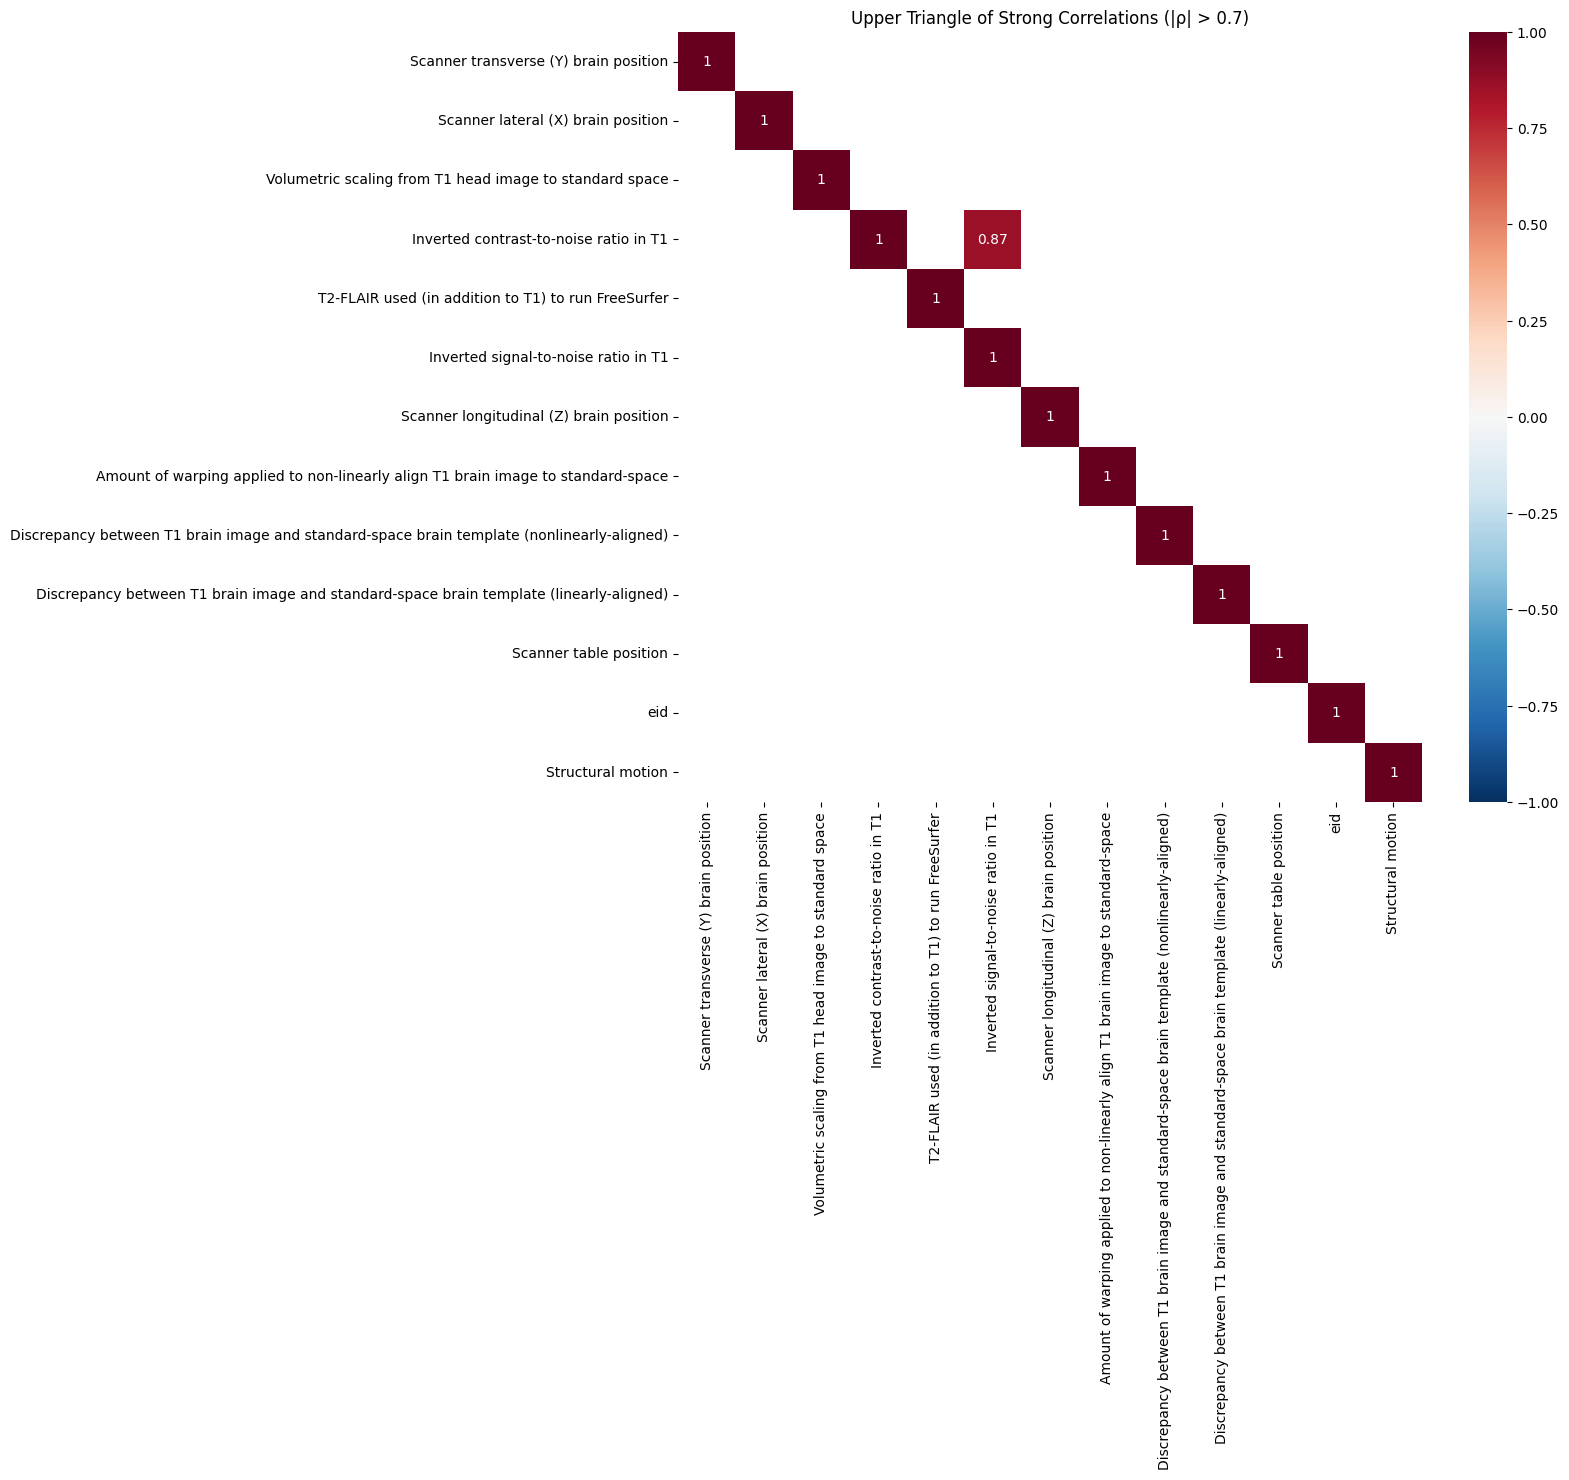

In [5]:
# Compute correlations between confounds
struct_conf = pd.read_csv(os.path.join(data_path, 'sMRI/t1_struct_conf.csv'))
rho, p = spearmanr(struct_conf)
p = pd.DataFrame(p, columns = struct_conf.columns, index=struct_conf.columns).T
rho = pd.DataFrame(rho, columns = struct_conf.columns, index=struct_conf.columns).T
rho_sign = rho.where(rho > 0.7)
# Plot corelations between confounds
mask = np.triu(np.ones_like(rho, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(rho.where(mask & (np.abs(rho)>0.7)), 
            annot=True, 
            cmap='RdBu_r',
            center=0,
            vmin=-1, vmax=1)
plt.title("Upper Triangle of Strong Correlations (|ρ| > 0.7)")
plt.show()

In [9]:
# Drop highly correlated confounds and save
struct_conf = struct_conf.drop(columns = ['Inverted contrast-to-noise ratio in T1'])
struct_conf.to_csv(os.path.join(data_path, 'sMRI/t1_struct_conf.csv'), index=False)

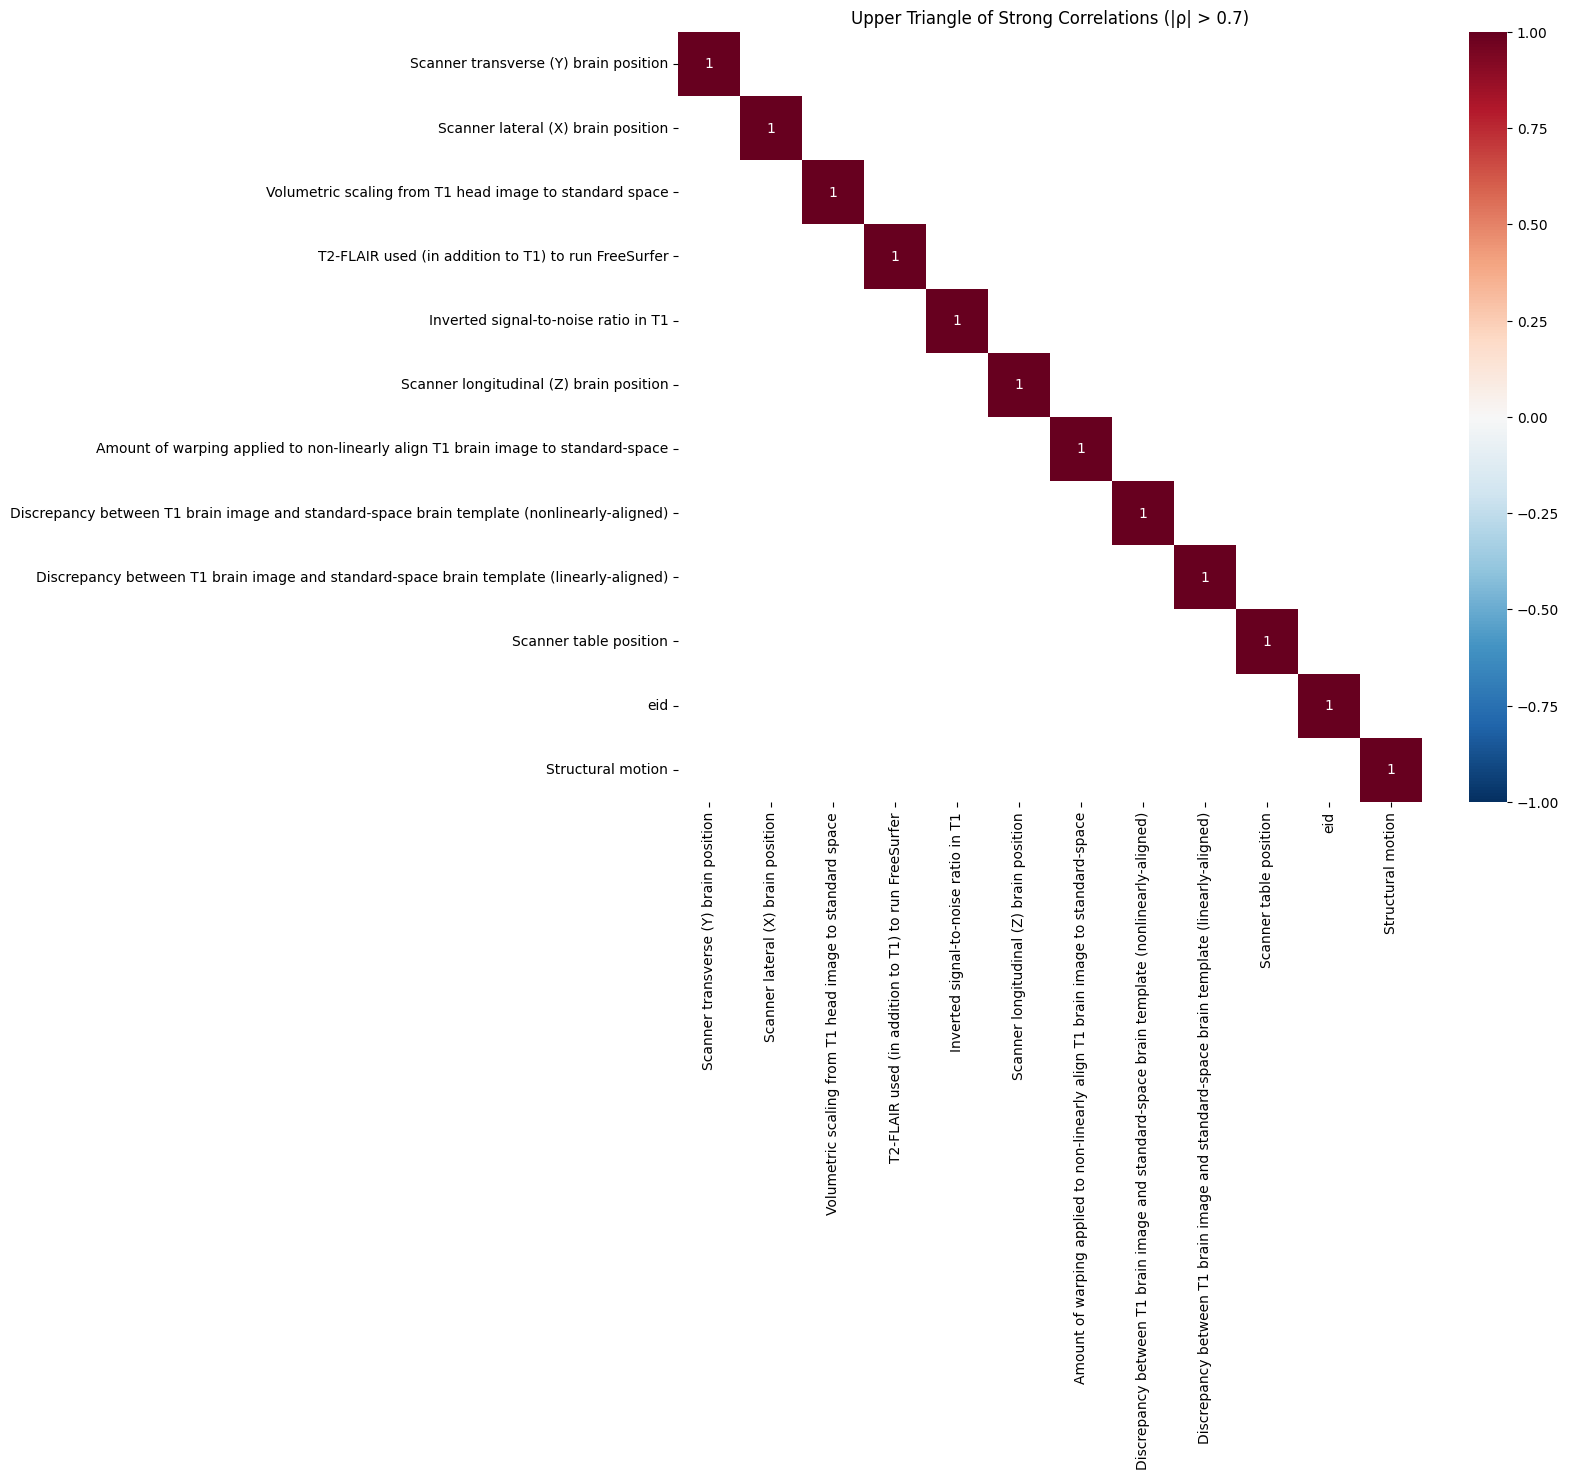

In [ ]:
# Confirm that confounds are not not correlated
rho, p = spearmanr(struct_conf)
p = pd.DataFrame(p, columns = struct_conf.columns, index=struct_conf.columns).T
rho = pd.DataFrame(rho, columns = struct_conf.columns, index=struct_conf.columns).T
rho_sign = rho.where(rho > 0.7)
# Plot corelations between confounds
mask = np.triu(np.ones_like(rho, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(rho.where(mask & (np.abs(rho)>0.7)), 
            annot=True, 
            cmap='RdBu_r',
            center=0,
            vmin=-1, vmax=1)
plt.title("Upper Triangle of Strong Correlations (|ρ| > 0.7)")
plt.show()

In [ ]:
# Final list of T1w confounds
pd.read_csv(os.path.join(data_path, 'sMRI/t1_struct_conf.csv')).columns.to_list()

['Scanner transverse (Y) brain position',
 'Scanner lateral (X) brain position',
 'Volumetric scaling from T1 head image to standard space',
 'T2-FLAIR used (in addition to T1) to run FreeSurfer',
 'Inverted signal-to-noise ratio in T1',
 'Scanner longitudinal (Z) brain position',
 'Amount of warping applied to non-linearly align T1 brain image to standard-space',
 'Discrepancy between T1 brain image and standard-space brain template (nonlinearly-aligned)',
 'Discrepancy between T1 brain image and standard-space brain template (linearly-aligned)',
 'Scanner table position',
 'eid',
 'Structural motion']

# T2w confounds

#### T2-specific:
- 25926	Intensity scaling for T2_FLAIR - exclude due to low variability
- 25736	Discrepancy between T2 FLAIR brain image and T1 brain image


#### Structural confounds + common confounds:

- 25756	Scanner lateral (X) brain position
- 25757	Scanner transverse (Y) brain position
- 25758	Scanner longitudinal (Z) brain position
- 25759	Scanner table position
- 25000 Volumetric scaling from T1 head image to standard space ('Head size')
- 24419 Measure of head motion in T1 structural image

In [ ]:
df_add_t2_conf = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
#25926, #Intensity scaling for T2_FLAIR
25736, #Discrepancy between T2 FLAIR brain image and T1 brain image
], instance=2)
add_t2_conf_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_add_t2_conf)

add_t2_conf_names_nona = add_t2_conf_names.dropna(axis=0)
add_t2_conf_names_nona.columns = add_t2_conf_names_nona.columns.str.replace('-2.0', '')

t2_conf = pd.merge(struct_conf[
['eid',
'Scanner transverse (Y) brain position',
'Scanner lateral (X) brain position',
'Scanner longitudinal (Z) brain position',
'Scanner table position',
#'Inverted contrast-to-noise ratio in T1',
#'Inverted signal-to-noise ratio in T1',
#'T2-FLAIR used (in addition to T1) to run FreeSurfer',
'Amount of warping applied to non-linearly align T1 brain image to standard-space',
'Discrepancy between T1 brain image and standard-space brain template (nonlinearly-aligned)',
'Discrepancy between T1 brain image and standard-space brain template (linearly-aligned)',
'Volumetric scaling from T1 head image to standard space',
'Structural motion']
], add_t2_conf_names_nona, on = 'eid')
t2_conf.to_csv(os.path.join(data_path, 'sMRI/t2_struct_conf.csv'), index=False)
print(t2_conf.columns.to_list())
print(t2_conf.shape)

['eid', 'Scanner transverse (Y) brain position', 'Scanner lateral (X) brain position', 'Scanner longitudinal (Z) brain position', 'Scanner table position', 'Amount of warping applied to non-linearly align T1 brain image to standard-space', 'Discrepancy between T1 brain image and standard-space brain template (nonlinearly-aligned)', 'Discrepancy between T1 brain image and standard-space brain template (linearly-aligned)', 'Volumetric scaling from T1 head image to standard space', 'Structural motion', 'Discrepancy between T2 FLAIR brain image and T1 brain image']
(44413, 11)


In [ ]:
# Summary
with pd.option_context('display.max_columns', None):
    display(t2_conf.drop(columns = 'eid').describe().round(2))

,Scanner transverse (Y) brain position,Scanner lateral (X) brain position,Scanner longitudinal (Z) brain position,Scanner table position,Amount of warping applied to non-linearly align T1 brain image to standard-space,Discrepancy between T1 brain image and standard-space brain template (nonlinearly-aligned),Discrepancy between T1 brain image and standard-space brain template (linearly-aligned),Volumetric scaling from T1 head image to standard space,Structural motion,Discrepancy between T2 FLAIR brain image and T1 brain image
count,44413.00,44413.00,44413.00,44413.00,44413.00,44413.00,44413.00,44413.00,44413.00,44413.00
mean,66.60,0.78,-29.21,-1053.21,0.08,0.49,0.66,1.30,0.34,0.35
std,6.01,3.10,25.91,24.13,0.02,0.03,0.04,0.12,0.15,0.05
min,52.00,-41.09,-96.70,-1197.00,0.05,0.36,0.55,0.80,-1.86,0.19
25%,62.00,-1.10,-45.00,-1042.00,0.07,0.47,0.64,1.21,0.24,0.32
50%,66.00,0.66,-34.98,-1042.00,0.07,0.49,0.66,1.30,0.32,0.35
75%,71.00,2.56,-23.11,-1042.00,0.08,0.52,0.69,1.38,0.42,0.38
max,96.00,18.24,124.46,-1020.00,0.54,0.67,0.89,1.94,6.96,0.92


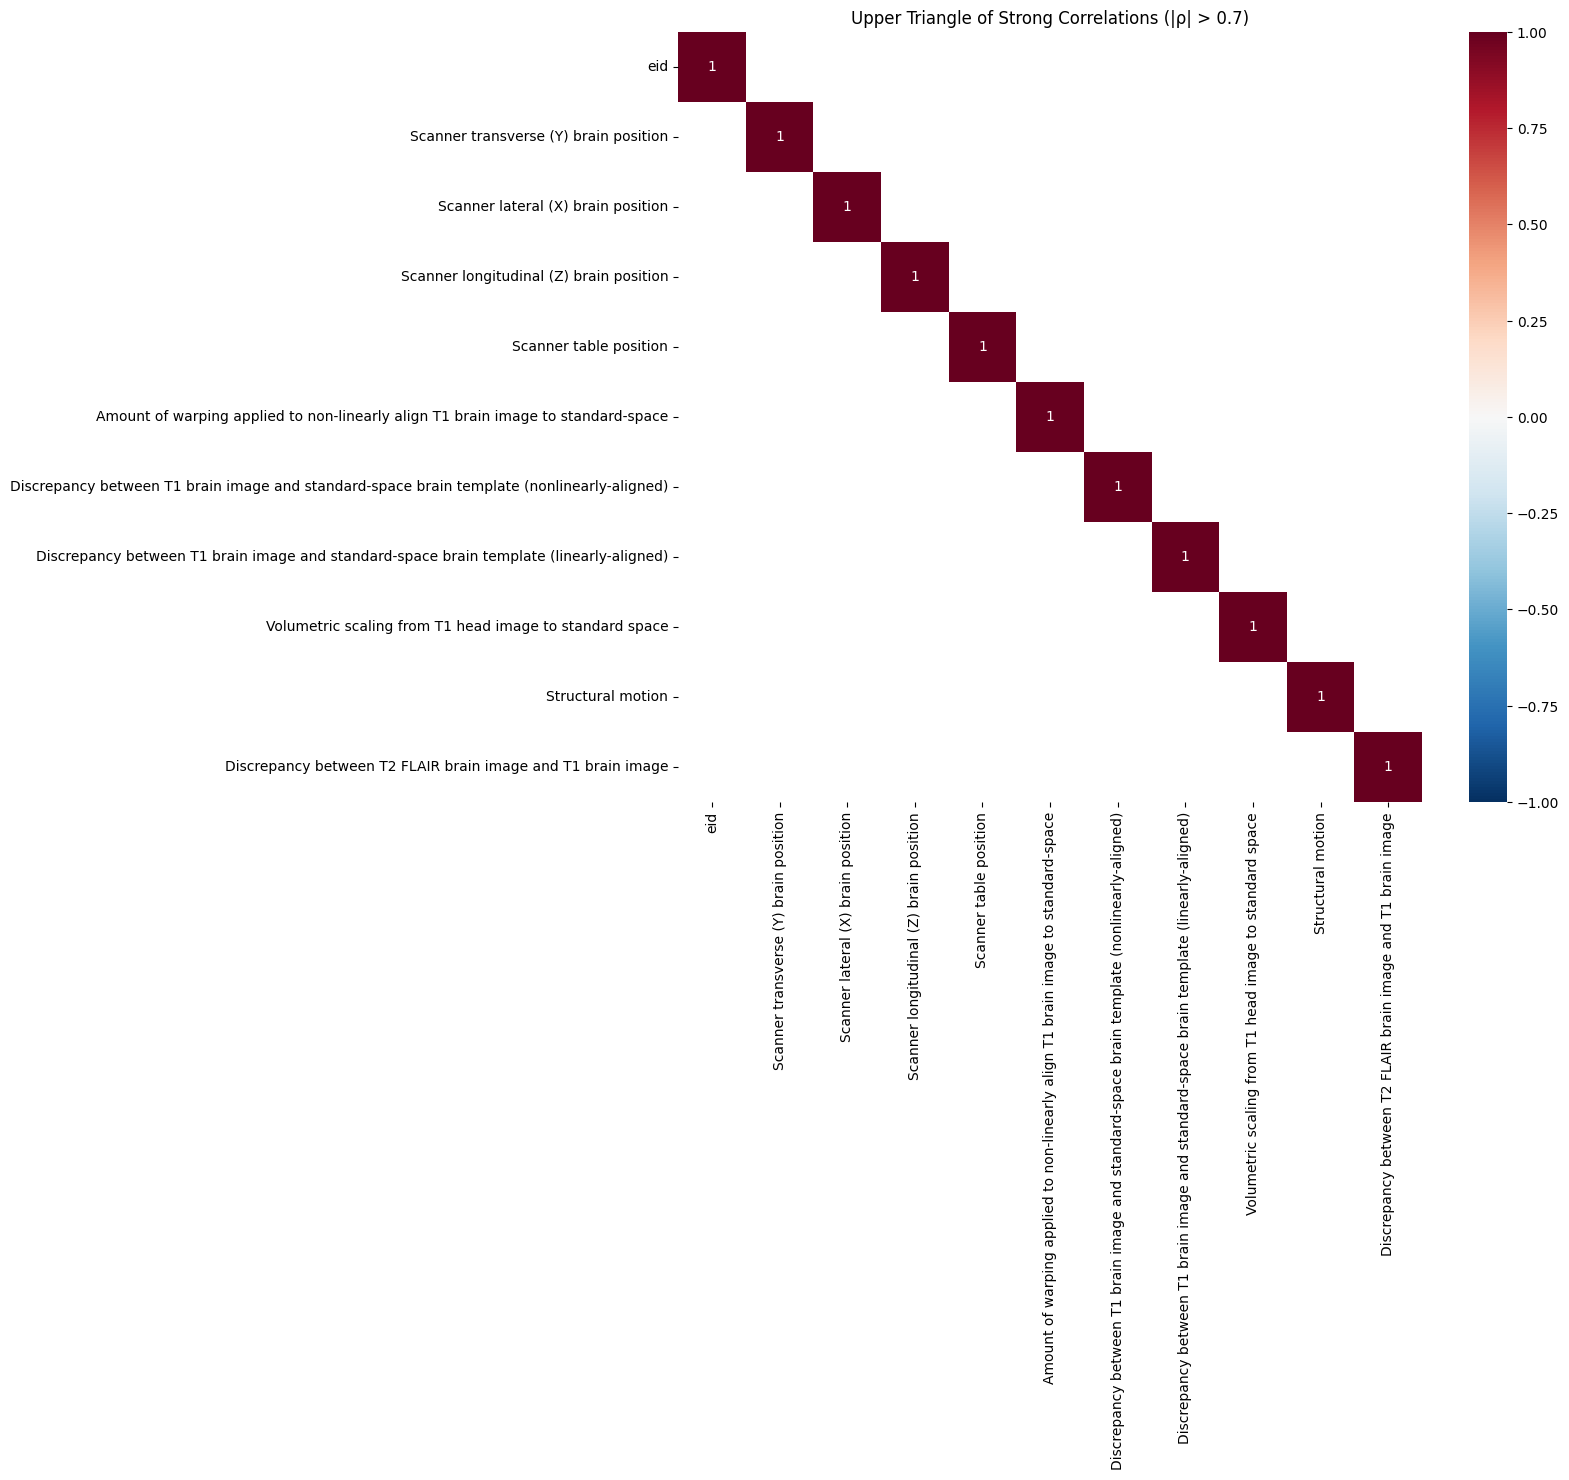

In [11]:
# Compute correlations between confounds
t2_conf = pd.read_csv(os.path.join(data_path, 'sMRI/t2_struct_conf.csv'))
rho, p = spearmanr(t2_conf)
p = pd.DataFrame(p, columns = t2_conf.columns, index=t2_conf.columns).T
rho = pd.DataFrame(rho, columns = t2_conf.columns, index=t2_conf.columns).T
rho_sign = rho.where(rho > 0.7)
# Plot corelations between confounds
mask = np.triu(np.ones_like(rho, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(rho.where(mask & (np.abs(rho)>0.7)), 
            annot=True, 
            cmap='RdBu_r',
            center=0,
            vmin=-1, vmax=1)
plt.title("Upper Triangle of Strong Correlations (|ρ| > 0.7)")
plt.show()